In [1]:
import os
# os.chdir("D:/אוניברסיטה/מעבדה/all code")
import parsing_data
import pandas as pd
import numpy as np
import MethodAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
import ToolsForTemporalAnalysis
import interpolation_methods
import gLV_interpolation
import copy
import scipy
from IPython.display import display
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")
import math
from datetime import datetime
import scipy
import sklearn

import importlib
importlib.reload(parsing_data)
importlib.reload(ToolsForTemporalAnalysis)


<module 'ToolsForTemporalAnalysis' from 'D:\\אוניברסיטה\\מעבדה\\all code\\ToolsForTemporalAnalysis.py'>

# Data parsing

In [2]:
#parsing 

number_of_top_spec = 30


# donors_data_loc = "D:\\אוניברסיטה\\מעבדה\\donors\\6_Taxonomy\\taxa_genus_table_compo_exported\\feature-table.tsv"
donors_data_loc = "feature-table.tsv"
# donors_metadata_loc = "D:\\אוניברסיטה\\מעבדה\\donors\\metadata_for_qiime.txt"
donors_metadata_loc = "metadata_for_qiime.txt"

# moving_pictures_data_loc = "D:\\אוניברסיטה\\מעבדה\\Moving pictures\\M3_feces_L6.txt"
moving_pictures_data_loc = "M3_feces_L6.txt"
# moving_pictures_data_loc_F4 = "D:\\אוניברסיטה\\מעבדה\\Moving pictures\\F4_feces_L6.txt"
moving_pictures_data_loc_F4 = "F4_feces_L6.txt"

# trosvic_metadata_loc = "D:\\אוניברסיטה\\מעבדה\\TROSVIC\\metadata.txt"
# trosvic_feature_table_loc = "D:\\אוניברסיטה\\מעבדה\\TROSVIC\\taxonomy.tsv"
# trosvic_data_loc = "D:\\אוניברסיטה\\מעבדה\\TROSVIC\\feature-table-scandinavian.tsv"
trosvic_metadata_loc = "metadata.txt"
trosvic_feature_table_loc = "taxonomy.tsv"
trosvic_data_loc = "feature-table-scandinavian.tsv"


moving_pictures_data, moving_pictures_data_F4 = parsing_data.moving_picrtures_parsing(moving_pictures_data_loc, 
                                                                              moving_pictures_data_loc_F4, number_of_top_spec)
donors_data = parsing_data.donors_parsing(donors_data_loc, donors_metadata_loc, number_of_top_spec)
trosvic_data = parsing_data.trosvic_parsing(trosvic_metadata_loc, trosvic_feature_table_loc,trosvic_data_loc, number_of_top_spec)

color_per_method = {'KNN': [255 / 255,149 / 255,13 / 255], 'spline': [255 / 255,150 / 255,203 / 255], 'weighted average':[235 / 255,89 / 255,5 / 255], 
                    'MLRR': [255 / 255,226 / 255,0 / 255], "LIMITS": [255 / 255,100 / 255,150 / 255], "gLV MSE": [150 / 255,50 / 255,100 / 255],
                    'average': [201 / 255,200 / 255,8 / 255], 'median' : [7 / 255,232 / 255, 55 / 255], 'last time point': [13 / 255,255 / 255, 211 / 255],
                    'sparse DBN': [180/ 255, 0, 1], 'dense DBN': [111/ 255,13/ 255,1]}

marker_per_method = {'KNN': "D", 'spline': "8", 'weighted average':"D", 
                    'MLRR': "*",  "LIMITS": "*", "gLV MSE": "*",
                    'average': "s", 'median' : "s", 'last time point': "s",
                    'sparse DBN': "P", 'dense DBN': "P"}


methods_to_draw_order = ['dense DBN', 'sparse DBN', 'spline', 'KNN', 'weighted average', 
                         'last time point', 'average', 'median', "MLRR", "LIMITS", "gLV MSE"]

### Reading interpolation results

In [3]:
# path = "D:\\אוניברסיטה\\מעבדה\\all code\\all interpolation results\\"
path = "all interpolation results\\"


removing_one_day_by_individual = {}

for patient in os.listdir(path):
    all_methods = os.listdir(path + patient)
    cur_pat_dict = {}
    for cur_method in all_methods: 
        cur_method_df = pd.read_csv(path + patient + "\\" + cur_method, header = None)
        cur_method_list = [list(cur_method_df.iloc[i,:]) for i in range(cur_method_df.shape[0])]
        cur_pat_dict[cur_method[:cur_method.index(".csv")]] = cur_method_list
    removing_one_day_by_individual[patient] = cur_pat_dict
    
    

time_points_per_patient = {}
for patient in donors_data:
    time_points_per_patient["donors " + patient] = list(donors_data[patient].columns)

time_points_per_patient["moving pictures M3"] = list(moving_pictures_data.columns)
time_points_per_patient["moving pictures F4"] = list(moving_pictures_data_F4.columns)

for patient in trosvic_data:
    time_points_per_patient["trosvic " + patient] = list(trosvic_data[patient].columns)


### BC Calculation

In [4]:
bray_curtis_per_patient = {}
for patient in removing_one_day_by_individual:
    tmp_patient = copy.deepcopy(removing_one_day_by_individual[patient])
    tmp_real_data = np.array(tmp_patient["real data"])
    del tmp_patient["real data"]
    for method in tmp_patient:
        tmp_patient[method] = np.array(tmp_patient[method])
    bray_curtis_per_patient[patient] = ToolsForTemporalAnalysis.bray_curtis_for_all_methods(tmp_real_data, tmp_patient)



In [5]:
all_methods = ["equal", "last time point", "average", "median", "KNN", "MLRR", "gLV MSE", "LIMITS", "spline",
              "weighted average", "sparse DBN", "dense DBN"]
methods_dict = {}
counter = 0
for method in all_methods:
    counter += 1
    methods_dict[method] = counter


bc_df = pd.DataFrame(columns = ["patient", "method", "bc", "counter"])
for patient in list(bray_curtis_per_patient.keys()):
    for method in bray_curtis_per_patient[patient].keys():
        tmp_bc_df = pd.DataFrame([[patient, method, bray_curtis_per_patient[patient][method][i], methods_dict[method]] 
         for i in range(len(bray_curtis_per_patient[patient][method]))], columns = ["patient", "method", "bc", "counter"])
        bc_df = pd.concat((bc_df, tmp_bc_df))
bc_df = bc_df.sort_values(by = "counter", axis = 0)

bc_df_donors = pd.DataFrame(columns = ["method", "bc", "patient"])
bc_df_trosvic = pd.DataFrame(columns = ["method", "bc", "patient"])
bc_df_moving_pictures = pd.DataFrame(columns = ["method", "bc", "patient"])
bc_df_all_shortened = pd.DataFrame(columns = ["method", "bc", "patient"])


for i in range(bc_df.shape[0]):
    
    if "donors " in bc_df.iloc[i,0]:
        tmp_bc_df = pd.DataFrame([[bc_df.iloc[i,1], float(bc_df.iloc[i,2]), bc_df.iloc[i,0]]],
                                  columns = ["method", "bc", "patient"])
        bc_df_donors = pd.concat((bc_df_donors, tmp_bc_df))
    elif "trosvic " in bc_df.iloc[i,0]:
        tmp_bc_df = pd.DataFrame([[bc_df.iloc[i,1], float(bc_df.iloc[i,2]), bc_df.iloc[i,0]]],
                                  columns = ["method", "bc", "patient"])
        bc_df_trosvic = pd.concat((bc_df_trosvic, tmp_bc_df))
    elif "moving pictures" in bc_df.iloc[i,0]:
        tmp_bc_df = pd.DataFrame([[bc_df.iloc[i,1], float(bc_df.iloc[i,2]), bc_df.iloc[i,0]]],
                                  columns = ["method", "bc", "patient"])
        bc_df_moving_pictures = pd.concat((bc_df_moving_pictures, tmp_bc_df))
    
    bc_df_all_shortened = pd.concat((bc_df_all_shortened, tmp_bc_df))

bc_df_all_grouped = bc_df_all_shortened.groupby(by = "method").mean().sort_values(by = "bc", ascending = True)
bc_df_all_grouped["order"] = [i for i in range(bc_df_all_grouped.shape[0])]

bc_df_donors_grouped = bc_df_donors.groupby(by = "method").mean().sort_values(by = "bc", ascending = True)
bc_df_donors_grouped["order"] = [i for i in range(bc_df_donors_grouped.shape[0])]

bc_df_trosvic_grouped = bc_df_trosvic.groupby(by = "method").mean().sort_values(by = "bc", ascending = True)
bc_df_trosvic_grouped["order"] = [i for i in range(bc_df_trosvic_grouped.shape[0])]

bc_df_moving_pictures_grouped = bc_df_moving_pictures.groupby(by = "method").mean().sort_values(by = "bc", ascending = True)
bc_df_moving_pictures_grouped["order"] = [i for i in range(bc_df_moving_pictures_grouped.shape[0])]




# Analysis

### correlation to adjacent time points 

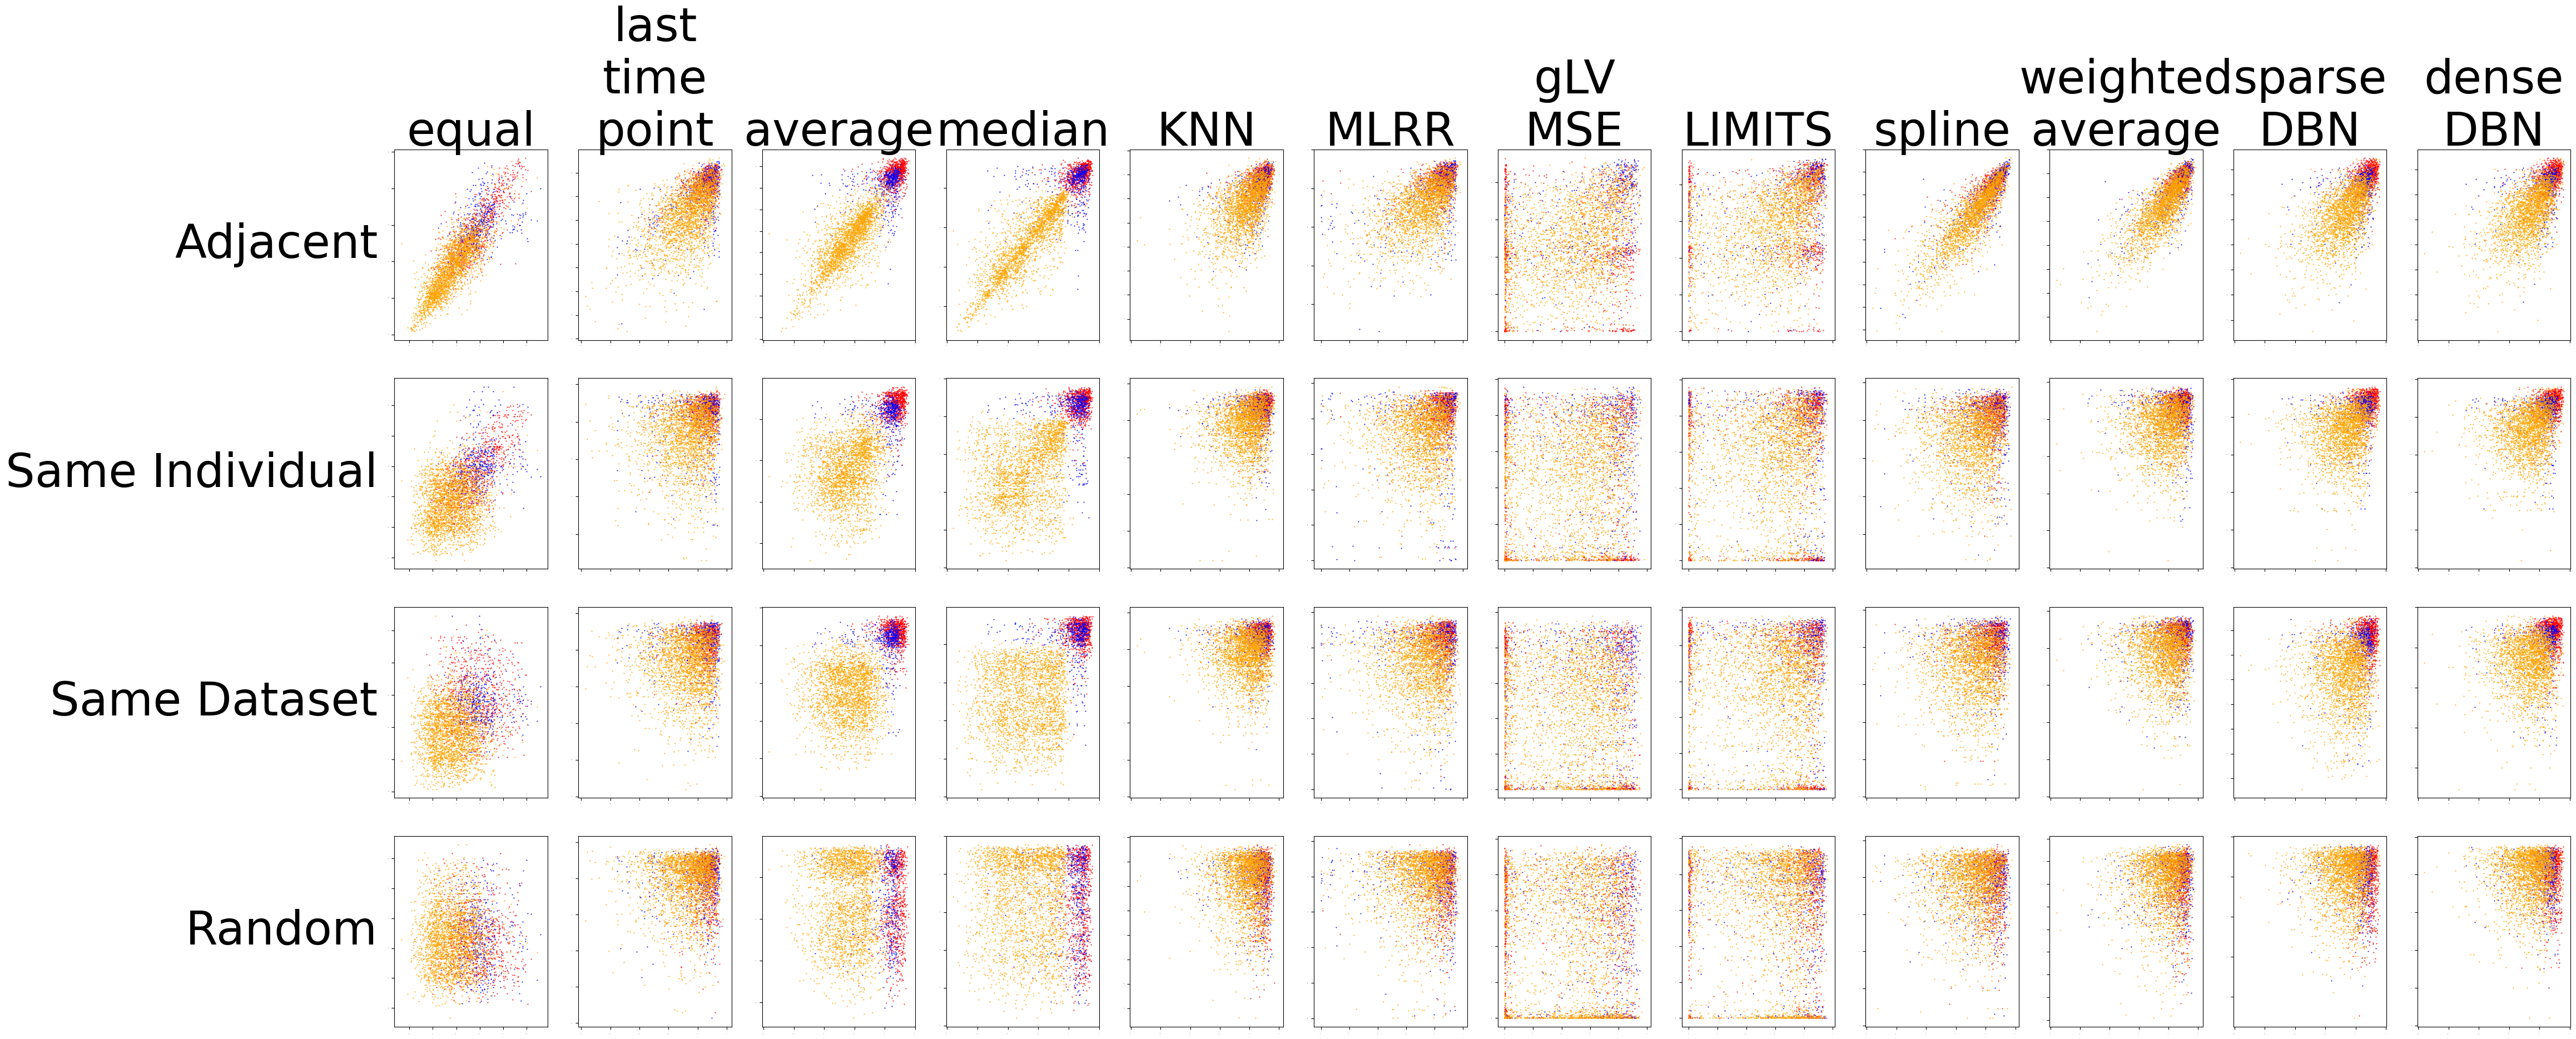

In [6]:
fig, axes = plt.subplots(nrows = 4, ncols = 12)
cur_subplot = 0
all_patients = list(bray_curtis_per_patient.keys())
all_methods = ["equal", "last time point", "average", "median", "KNN", "MLRR", "gLV MSE", "LIMITS", "spline",
              "weighted average", "sparse DBN", "dense DBN"]

bc_cor_methods = ["Adjacent", "Same Individual", "Same Dataset", "Random"]
corr_between_interpolation_acc_df = pd.DataFrame(index = ["Adjacent", "Same Individual", "Same Dataset", "Random"])
size_for_text = 60
labelsize = 40
plt.style.use('ggplot')

pad = 5
all_methods_text = ["equal", "last\ntime\npoint", "average", "median", "KNN", "MLRR", "gLV\nMSE", "LIMITS", "spline",
              "weighted\naverage", "sparse\nDBN", "dense\nDBN"]
for ax, method in zip(axes[0], all_methods_text):
    ax.annotate(method, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                ha='center', va='baseline', size = size_for_text)

for ax, cor_method in zip(axes[:,0], bc_cor_methods):
    ax.annotate(cor_method, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', size = size_for_text)

for j in range(len(all_methods)):
    method = all_methods[j]
    adjacent_tp = []
    cur_tp_for_adjacent= []
    cur_tp_not_adjacent = []
    cur_random_patient = []
    cur_random_dataset = []
    cur_random_all = []
    for patient in all_patients:
        tmp_data = bray_curtis_per_patient[patient][method]
        for i in range(len(tmp_data)):
            ##last and next timepoint correlation
            if 0<i <len(tmp_data) - 1:
                ax = axes[0][j]
                if j != 0:
                    ax.tick_params(axis='y', which='major', labelsize=0)
                else:
                    ax.tick_params(axis='y', which='major', labelsize=labelsize)
                    ax.tick_params(axis='y', which='major', labelsize=0)
                ax.tick_params(axis='x', which='major', labelsize=0)
                
                if "donors" in patient:
                    ax.plot(tmp_data[i], (tmp_data[i - 1] + tmp_data[i + 1] )/ 2  ,
                         marker=".", color="red", markersize = 1)
                elif "trosvic" in patient:
                    ax.plot(tmp_data[i], (tmp_data[i - 1] + tmp_data[i + 1] )/ 2  ,
                         marker=".", color="orange", markersize = 1)
                else:
                    ax.plot(tmp_data[i], (tmp_data[i - 1] + tmp_data[i + 1] )/ 2  ,
                         marker=".", color="blue", markersize = 1)
                adjacent_tp.append((tmp_data[i - 1] + tmp_data[i + 1]) / 2)
                cur_tp_for_adjacent.append(tmp_data[i])
            #random time point, same patient
            
            cur_tp_not_adjacent.append(tmp_data[i])
            
            tmp_data_copy = copy.deepcopy(tmp_data)
            np.random.shuffle(tmp_data_copy)
            ax = axes[1][j]
            
            if j != 0:
                    ax.tick_params(axis='y', which='major', labelsize=0)
            else:
                    ax.tick_params(axis='y', which='major', labelsize=labelsize)
                    ax.tick_params(axis='y', which='major', labelsize=0)
            ax.tick_params(axis='x', which='major', labelsize=0)
            
            if "donors" in patient:
                    ax.plot(tmp_data[i], tmp_data_copy[0],
                         marker=".", color="red", markersize = 1)
            elif "trosvic" in patient:
                ax.plot(tmp_data[i], tmp_data_copy[0],
                         marker=".", color="orange", markersize = 1)
            else:
                ax.plot(tmp_data[i], tmp_data_copy[0],
                         marker=".", color="blue", markersize = 1)
            
            cur_random_patient.append(tmp_data_copy[0])
            
            ax = axes[2][j]
            if j != 0:
                    ax.tick_params(axis='y', which='major', labelsize=0)
            else:
                    ax.tick_params(axis='y', which='major', labelsize=labelsize)
                    ax.tick_params(axis='y', which='major', labelsize=0)
            ax.tick_params(axis='x', which='major', labelsize=0)
            
            
            if "donors" in patient:
                all_donors = copy.deepcopy(list(donors_data.keys()))
                random_pat = all_donors[np.random.randint(len(all_donors))]
                random_pat_bc = bray_curtis_per_patient["donors " + random_pat][method]
                random_val = random_pat_bc[np.random.randint(len(random_pat_bc))]
                ax.plot(tmp_data[i], random_val,
                         marker=".", color="red", markersize = 1)
            elif "trosvic" in patient:
                all_trosvic = copy.deepcopy(list(trosvic_data.keys()))
                random_pat = all_trosvic[np.random.randint(len(all_trosvic))]
                random_pat_bc = bray_curtis_per_patient["trosvic " + random_pat][method]
                random_val = random_pat_bc[np.random.randint(len(random_pat_bc))]
                ax.plot(tmp_data[i], random_val,
                         marker=".", color="orange", markersize = 1)
                
            else:
                
                random_pat = ["moving pictures M3", "moving pictures F4"][np.random.randint(2)]
                random_pat_bc = bray_curtis_per_patient[random_pat][method]
                random_val = random_pat_bc[np.random.randint(len(random_pat_bc))]
                ax.plot(tmp_data[i], random_val,
                         marker=".", color="blue", markersize = 1)
            cur_random_dataset.append(random_val)
            
            ax = axes[3][j]
            if j != 0:
                    ax.tick_params(axis='y', which='major', labelsize=0)
            else:
                    ax.tick_params(axis='y', which='major', labelsize=labelsize)
                    ax.tick_params(axis='y', which='major', labelsize=0)
            ax.tick_params(axis='x', which='major', labelsize=labelsize, rotation = 90)
            ax.tick_params(axis='x', which='major', labelsize=0, rotation = 90)
            
            tmp_patient = all_patients[np.random.randint(len(all_patients))]
            tmp_bc_values_to_draw_from = bray_curtis_per_patient[tmp_patient][method]
            random_val = tmp_bc_values_to_draw_from[np.random.randint(len(tmp_bc_values_to_draw_from))]
            
            cur_random_all.append(random_val)
            
            if "donors" in patient:
                ax.plot(tmp_data[i], random_val,
                         marker=".", color="red", markersize = 1)
            elif "trosvic" in patient:
                ax.plot(tmp_data[i], random_val,
                         marker=".", color="orange", markersize = 1)
                
            else:
                ax.plot(tmp_data[i], random_val,
                         marker=".", color="blue", markersize = 1)
        corr_between_interpolation_acc_df[method] = [pd.DataFrame([cur_tp_for_adjacent, adjacent_tp]).T.dropna().corr().iloc[0,1],
                                          pd.DataFrame([cur_random_patient , cur_tp_not_adjacent]).T.dropna().corr().iloc[0,1],
                                                     pd.DataFrame([cur_random_dataset , cur_tp_not_adjacent]).T.dropna().corr().iloc[0,1],
                                                     pd.DataFrame([cur_random_all , cur_tp_not_adjacent]).T.dropna().corr().iloc[0,1]]

fig.set_size_inches(50.5, 20.5)
plt.show()

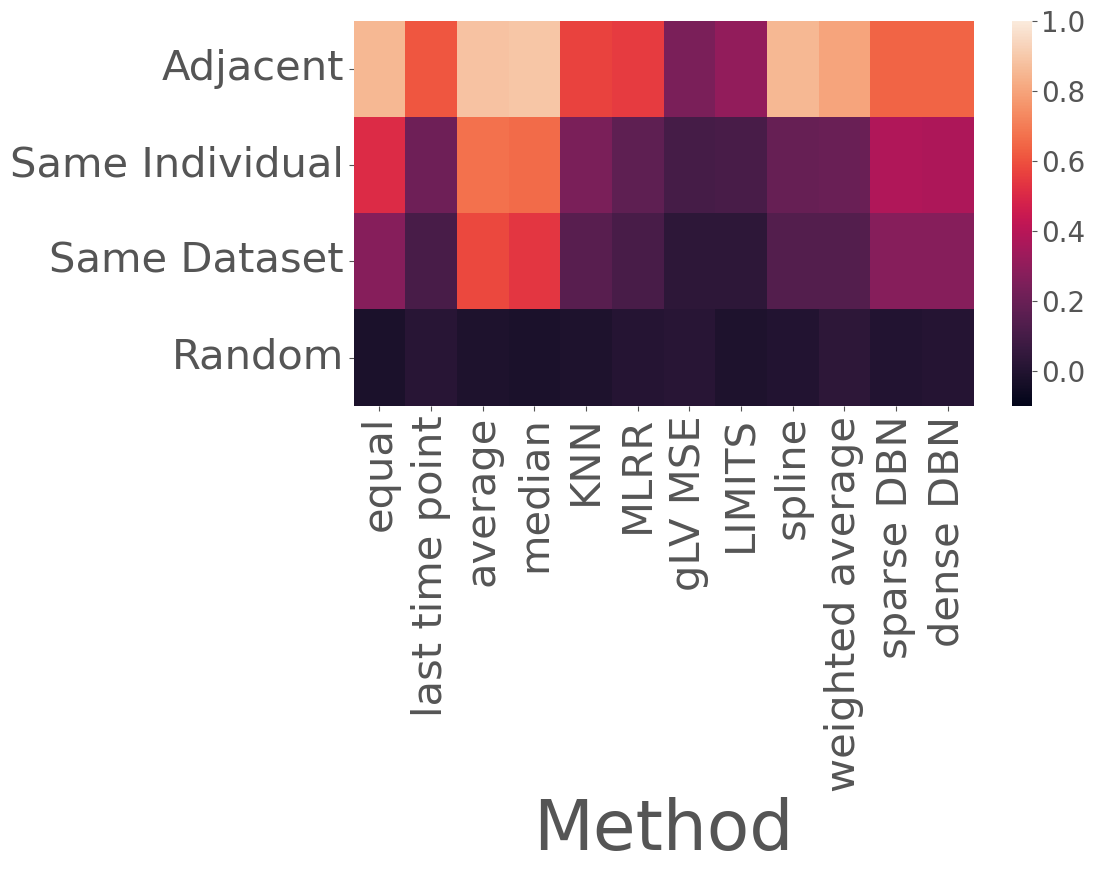

In [7]:
plt.figure(figsize = (10, 5))
ax = sns.heatmap(corr_between_interpolation_acc_df.round(2),vmin = -0.1, vmax = 1, annot=False, annot_kws={"fontsize":13, "fontweight" : "bold"})
plt.xlabel("Method", fontdict = {"size": 50})
plt.tick_params(axis='both', which='major', labelsize=30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

plt.show()

## Scores distribution

### all Data

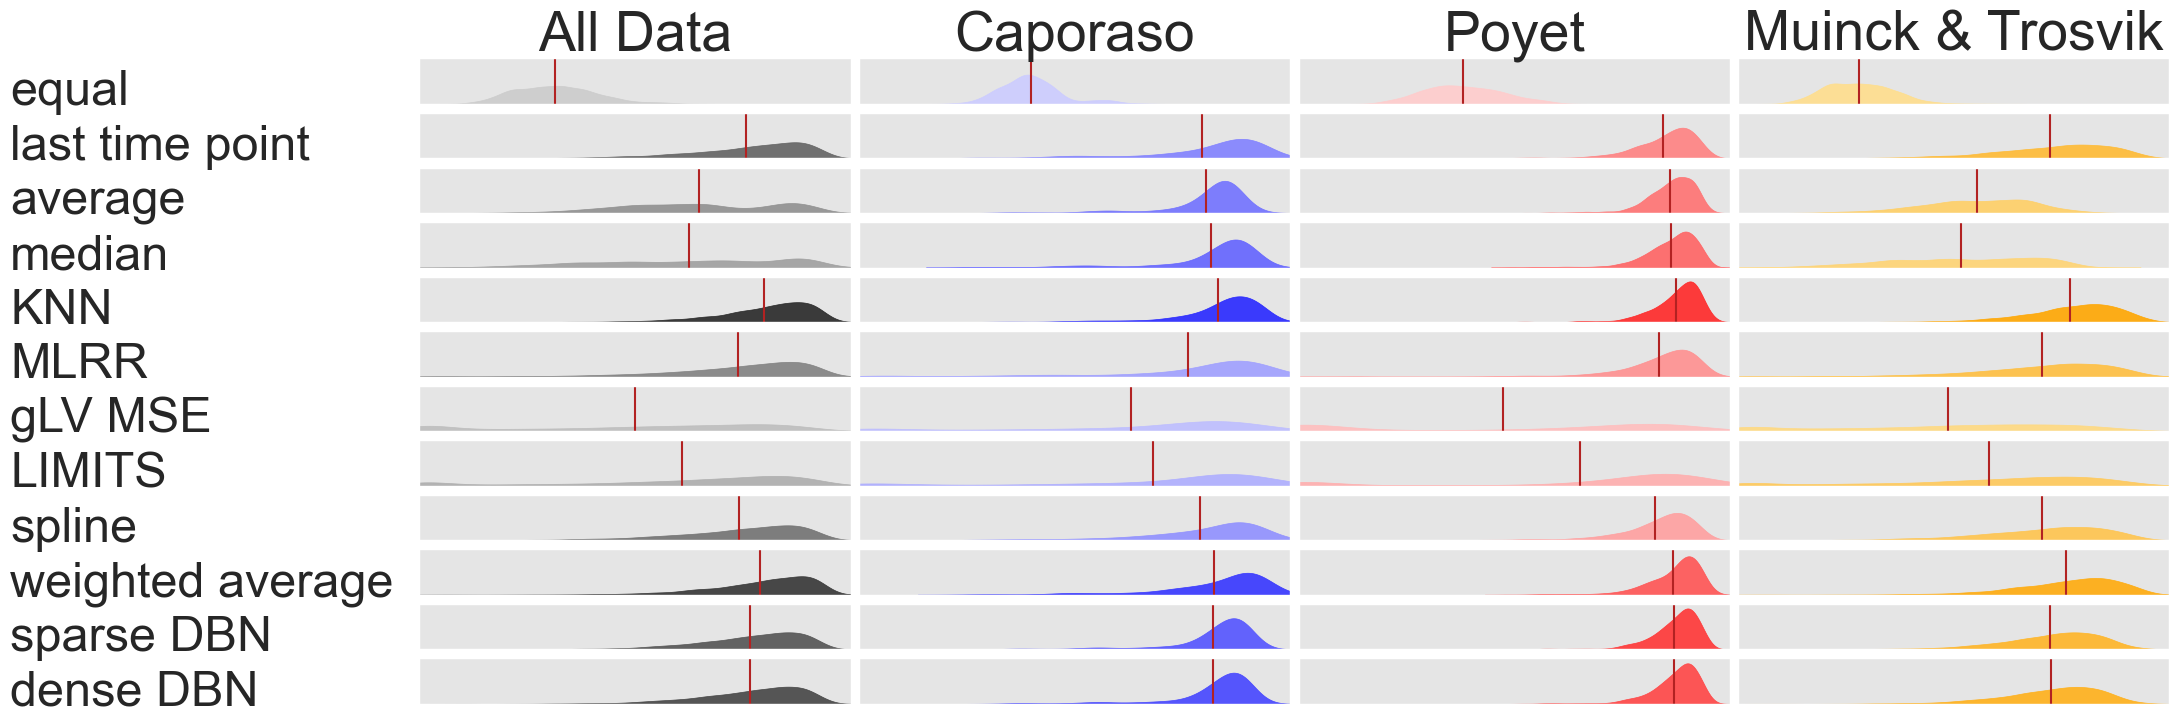

In [8]:
fig = plt.figure()
sns.set()
cur_subplot = 0
fontdict = {"size": 40}
plt.style.use('ggplot')
for method in all_methods:
    for i in range(4):
        cur_subplot += 1
        cur_plt = fig.add_subplot(len(all_methods) + 1, 4, cur_subplot)
        if cur_subplot % 4 == 1:
            tmp_all_data_to_use = bc_df_all_shortened[bc_df_all_shortened["method"] == method] 
            order_loc = bc_df_all_grouped.loc[method]["order"]
            color = [0.8 - order_loc * 1/17,0.8 - order_loc * 1/17,0.8 - order_loc * 1/17]
        elif cur_subplot % 4 == 3:
            tmp_all_data_to_use = bc_df_donors[bc_df_donors["method"] == method]
            order_loc = bc_df_donors_grouped.loc[method]["order"]
            color = [1,0.8 - order_loc * 1/17,0.8 - order_loc * 1/17]
        elif cur_subplot % 4 == 2:
            tmp_all_data_to_use = bc_df_moving_pictures[bc_df_moving_pictures["method"] == method]
            order_loc = bc_df_moving_pictures_grouped.loc[method]["order"]
            color = [0.8 - order_loc * 1/17,0.8 - order_loc * 1/17, 1]
        elif cur_subplot % 4 == 0:
            tmp_all_data_to_use = bc_df_trosvic[bc_df_trosvic["method"] == method]
            order_loc = bc_df_trosvic_grouped.loc[method]["order"]
            color = [1,0.87 - order_loc * 1/50, 0.55 - order_loc * 1/20]

        
            
        
        sns.kdeplot(list(tmp_all_data_to_use["bc"]), clip = [0,1], fill = True, 
                    color = color, alpha = 0.9)
        cur_plt.axvline(np.mean(tmp_all_data_to_use["bc"]), color = "firebrick")
        allaxes = fig.get_axes()
        ax = allaxes[-1]
        if cur_subplot % 4 == 1:
            ax.text(-0.95, .25, method,
                ha="left", va="center", transform=ax.transAxes, size = "35")
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_ylim(0,10)
        ax.set_xlim(0,1)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.yaxis.set_visible(False)
        ax.set_xlim([0.0000000001,0.99999999])
        
        
        if cur_subplot == 1:
            ax.set_title("All Data", fontdict = fontdict)
        elif cur_subplot == 3:
            ax.set_title("Poyet", fontdict = fontdict)
        elif cur_subplot == 2:
            ax.set_title("Caporaso", fontdict = fontdict)
        elif cur_subplot == 4:
            ax.set_title("Muinck & Trosvik", fontdict = fontdict)
        #sns.despine(ax = ax, top = True, bottom = True)
#         print("%s, %d mean results is %f" % (method, i, np.mean(tmp_all_data_to_use["bc"])))
fig.set_size_inches(25, 10)  
plt.subplots_adjust(left=0.5, bottom=0.5, right=1.2, top=1.2,
                wspace=0.02, hspace=0.2)




### individual level

In [9]:
tmp_all_pat = [pat[::-1] for pat in list(bc_df["patient"])]
tmp_all_pat = [pat[:pat.find(" ")][::-1] for pat in tmp_all_pat]
tmp_bc_df = copy.deepcopy(bc_df)
tmp_bc_df["patient"] = tmp_all_pat
drawing_ord = [pat[::-1] for pat in list(bc_df_donors["patient"])]
drawing_ord = list(set([pat[:pat.find(" ")][::-1] for pat in drawing_ord]))
drawing_ord.sort()
drawing_ord.append("M3")
drawing_ord.append("F4")
for i in range(1,13):
    drawing_ord.append("ID" + str(i))
    

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

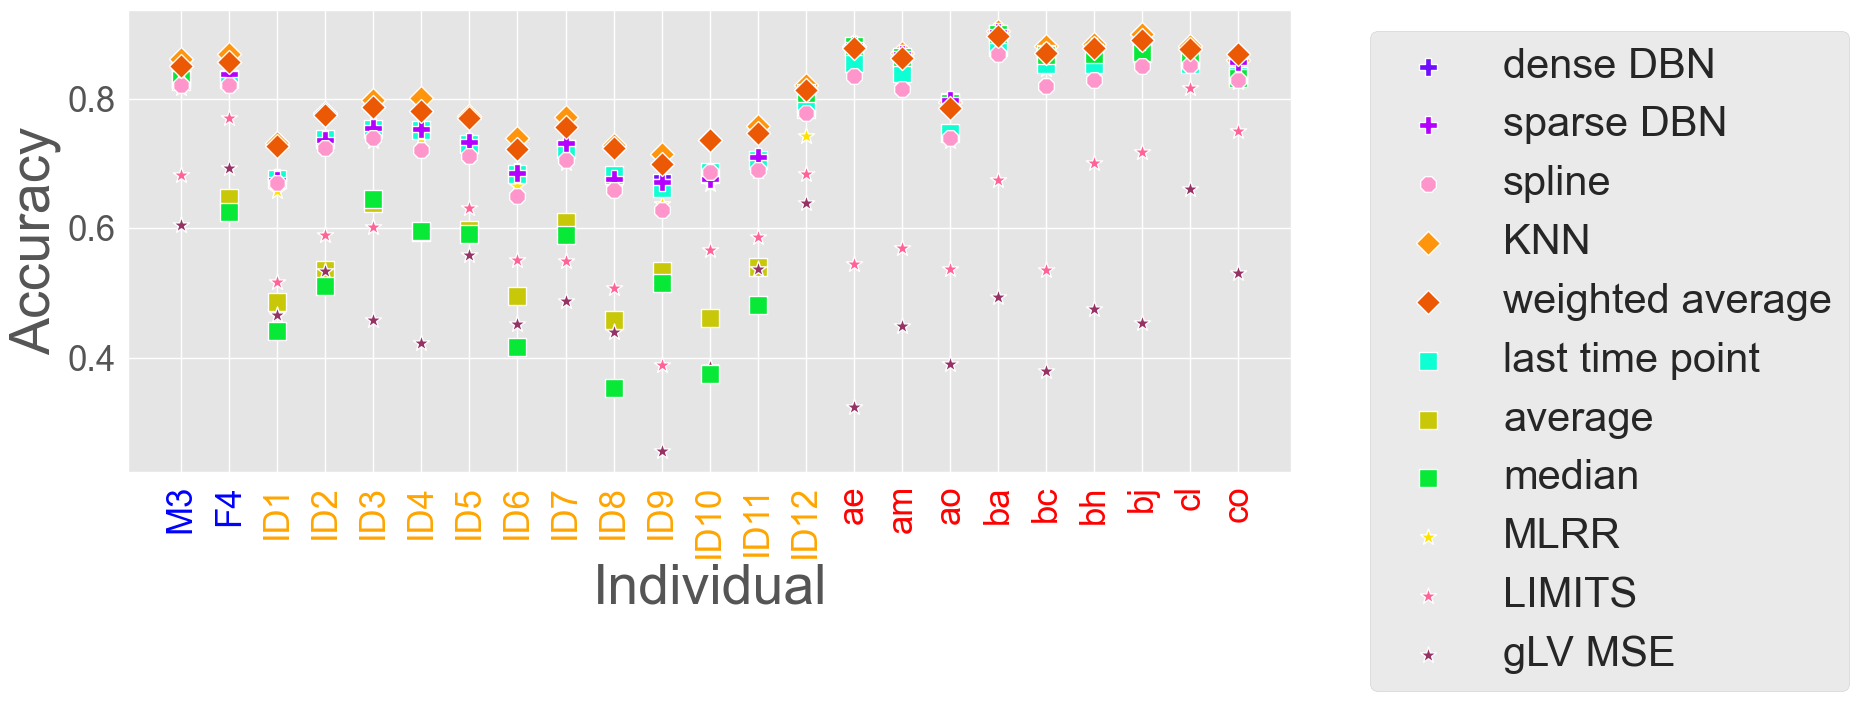

In [10]:
tmp_all_pat = [pat[::-1] for pat in list(bc_df["patient"])]
tmp_all_pat = [pat[:pat.find(" ")][::-1] for pat in tmp_all_pat]
tmp_bc_df = copy.deepcopy(bc_df)
tmp_bc_df["patient"] = tmp_all_pat
drawing_ord = ["M3", "F4"]
for i in range(1,13):
    drawing_ord.append("ID" + str(i))
tmp_ord_donors = [pat[::-1] for pat in list(bc_df_donors["patient"])]
tmp_ord_donors = list(set([pat[:pat.find(" ")][::-1] for pat in tmp_ord_donors]))
tmp_ord_donors.sort()
[drawing_ord.append(tmp_pat) for tmp_pat in tmp_ord_donors]



plt.figure(figsize=(15,6))
tmp_to_draw = copy.deepcopy(tmp_bc_df)
tmp_to_draw = tmp_bc_df[~((tmp_bc_df["method"] == "equal"))]#tmp_bc_df[~((tmp_bc_df["method"] == "equal") | (tmp_bc_df["method"] == "gLV MSE") | (tmp_bc_df["method"] == "LIMITS"))]
tmp = tmp_to_draw.groupby(by = ["method", "patient"]).mean().reset_index()
for method in tmp["method"].unique():

    sns.scatterplot(data = tmp[tmp["method"] == method], x="patient", y="bc", label = method, s = 150, c = color_per_method[method],
                     marker=marker_per_method[method])


plt.xticks(ticks=range(len(drawing_ord)), labels=drawing_ord, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=25)

# Set axis labels
plt.xlabel('Individual', fontsize=40)
plt.ylabel('Accuracy', fontsize=40)

# Color tick labels based on their group
for i, t in enumerate(plt.gca().get_xticklabels()):
    if i <= 1:
        t.set_color('blue')
    elif i <= 13:
        t.set_color('orange')
    else:
        t.set_color('red')


        
# Handling the legend
handles, labels = plt.gca().get_legend_handles_labels()

handles_labels_sorted = sorted(zip(handles, labels), key=lambda t: methods_to_draw_order.index(t[1]))
handles_sorted, labels_sorted = zip(*handles_labels_sorted)

# Create a new legend with the sorted handles and labels
plt.legend(handles_sorted, labels_sorted, fontsize=30, ncol=1, loc='upper left', bbox_to_anchor=(1.05, 1))


# Adjusting legend marker size (if needed)
# for line in legend.get_lines():
#     line.set_markersize(16)  # Example size
plt.show()

### Individual example

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

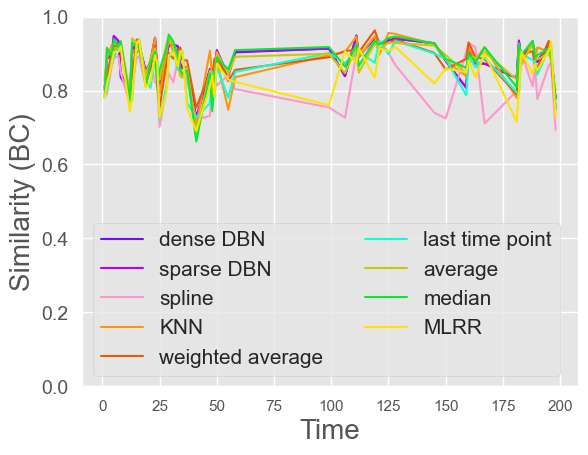

In [11]:
# tmp_to_draw = tmp_bc_df[~((tmp_bc_df["method"] == "equal") | (tmp_bc_df["method"] == "gLV MSE") | (tmp_bc_df["method"] == "LIMITS"))]

plt.style.use('ggplot')
for method in methods_to_draw_order:
    if method in ["equal", "gLV MSE", "LIMITS"]:
        continue
    plt.plot(donors_data["ae"].columns[1:-1], bray_curtis_per_patient["donors ae"][method], color = color_per_method[method],
            label = method)
plt.xlabel("Time", fontsize=20)
plt.ylabel("Similarity (BC)", fontsize=20)
plt.legend(fontsize=15, ncol=2)
plt.ylim(0, 1)
# plt.xticks([i for i in range(201,)], fontsize=5)
plt.yticks(fontsize=14)

### correlation between methods

In [12]:
mean_bc = tmp_to_draw.groupby(by = ["method", "patient"]).mean()
mean_bc.index[0][0]
mean_bc = mean_bc.reset_index()
mean_bc_table = pd.DataFrame(index = set(mean_bc["method"]), columns = set(mean_bc["patient"]), dtype= float)
for method in mean_bc_table.index:
    for patient in mean_bc_table.columns:
        mean_bc_table.loc[method, patient] = float(mean_bc[(mean_bc["method"] == method) & (mean_bc["patient"] == patient)]["bc"])
display(mean_bc_table.T.corr(method='pearson'))

scipy.stats.friedmanchisquare(mean_bc_table.iloc[:,0], mean_bc_table.iloc[:,1], mean_bc_table.iloc[:,2], 
                              mean_bc_table.iloc[:,3], mean_bc_table.iloc[:,4], mean_bc_table.iloc[:,5],
                             mean_bc_table.iloc[:,6], mean_bc_table.iloc[:,7], mean_bc_table.iloc[:,8], mean_bc_table.iloc[:,9],
                             mean_bc_table.iloc[:,10], mean_bc_table.iloc[:,11], mean_bc_table.iloc[:,12], 
                              mean_bc_table.iloc[:,13], mean_bc_table.iloc[:,14], mean_bc_table.iloc[:,15],
                             mean_bc_table.iloc[:,16], mean_bc_table.iloc[:,17], mean_bc_table.iloc[:,18],
                             mean_bc_table.iloc[:,19], mean_bc_table.iloc[:,20], mean_bc_table.iloc[:,21],
                             mean_bc_table.iloc[:,22])


gLV MSE  weighted average   average  dense DBN  sparse DBN  \
gLV MSE           1.000000          0.303370  0.144677   0.252077    0.256928   
weighted average  0.303370          1.000000  0.923227   0.987774    0.988599   
average           0.144677          0.923227  1.000000   0.964344    0.963299   
dense DBN         0.252077          0.987774  0.964344   1.000000    0.999876   
sparse DBN        0.256928          0.988599  0.963299   0.999876    1.000000   
median            0.153595          0.911763  0.993836   0.955983    0.954209   
LIMITS            0.791909          0.696571  0.522890   0.637373    0.641806   
last time point   0.286450          0.997817  0.926903   0.989842    0.990299   
KNN               0.292297          0.995411  0.924283   0.989538    0.990035   
MLRR              0.272204          0.994731  0.913042   0.983195    0.983698   
spline            0.358649          0.994746  0.917116   0.980478    0.981689   

                    median    LIMITS  last time point       KNN      MLRR  \
gLV MSE           0.153595  0.791909         0.286450  0.292297  0.272204   
weighted average  0.911763  0.696571         0.997817  0.995411  0.994731   
average           0.993836  0.522890         0.926903  0.924283  0.913042   
dense DBN         0.955983  0.637373         0.989842  0.989538  0.983195   
sparse DBN        0.954209  0.641806         0.990299  0.990035  0.983698   
median            1.000000  0.519756         0.916697  0.915898  0.900368   
LIMITS            0.519756  1.000000         0.677116  0.678566  0.670068   
last time point   0.916697  0.677116         1.000000  0.998416  0.995763   
KNN               0.915898  0.678566         0.998416  1.000000  0.994183   
MLRR              0.900368  0.670068         0.995763  0.994183  1.000000   
spline            0.906789  0.730405         0.990220  0.987641  0.986470   

                    spline  
gLV MSE           0.358649  
weighted average  0.994746  
average           0.917116  
dense DBN         0.980478  
sparse DBN        0.981689  
median            0.906789  
LIMITS            0.730405  
last time point   0.990220  
KNN               0.987641  
MLRR              0.986470  
spline            1.000000

FriedmanchisquareResult(statistic=191.288537549407, pvalue=5.707318292102508e-29)

In [13]:
# tmp_bc_df.groupby(by = ["patient", "method"]).mean().to_csv("D:\\method_patient.csv")
tmp_bc_df.groupby(by = ["patient", "method"]).mean().to_csv("method_patient.csv")

## relative error calculation 

In [14]:
min_max_per_patient = {}
for patient in removing_one_day_by_individual:
    tmp_patient = copy.deepcopy(removing_one_day_by_individual[patient])
    tmp_real_data = np.array(tmp_patient["real data"])
    del tmp_patient["real data"]
    for method in tmp_patient:
        tmp_patient[method] = np.array(tmp_patient[method])
    min_max_per_patient[patient] = ToolsForTemporalAnalysis.product_per_method(tmp_real_data, tmp_patient)

In [15]:
methods_size_df = pd.DataFrame(columns = ["dataset", "method", "patient", "bc", "counter"])
for method in removing_one_day_by_individual[list(removing_one_day_by_individual.keys())[0]].keys():
    print(method)
    if method == 'real data':
        continue
    for patient in removing_one_day_by_individual.keys():
        if "donors" in patient:
                dataset = "donors"
                color="red"
        elif "trosvic" in patient:
            color="orange"
            dataset = "trosvic"
        else:
            color="blue"
            dataset = "Moving Pictures"
        for i in range(len(bray_curtis_per_patient[patient][method])):
            methods_size_df = methods_size_df.append({"dataset": dataset, "patient": patient,"method":method,
                                  "bc" : bray_curtis_per_patient[patient][method][i], "counter": len(bray_curtis_per_patient[patient][method]) + 2}, ignore_index= True)


average
dense DBN
equal
gLV MSE
KNN
last time point
LIMITS
median
MLRR
real data
sparse DBN
spline
weighted average


## Correlation between time distance and accuracy

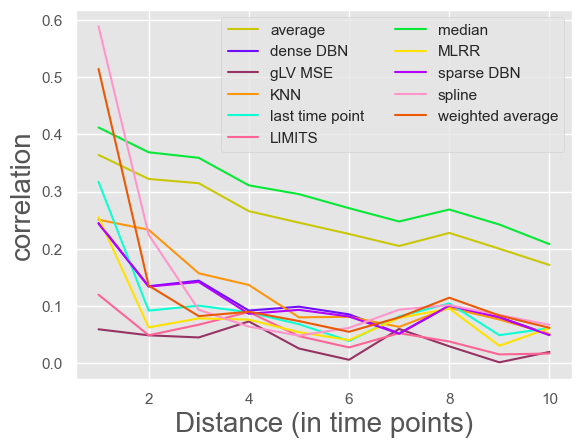

In [16]:
all_data_for_corr = pd.DataFrame(columns = ['average_pre', 'dense DBN_pre', 'equal_pre', 
                                         'gLV MSE_pre', 'KNN_pre',
       'last time point_pre', 'LIMITS_pre', 'median_pre', 'MLRR_pre',
       'sparse DBN_pre', 'spline_pre', 'weighted average_pre', 'average_post',
       'dense DBN_post', 'equal_post', 'gLV MSE_post', 'KNN_post',
       'last time point_post', 'LIMITS_post', 'median_post', 'MLRR_post',
       'sparse DBN_post', 'spline_post', 'weighted average_post'])

timepoint_difs = [i + 1 for i in range(10)]
all_methods = ['average', 'dense DBN', 'equal', 'gLV MSE', 'KNN', 
                                  'last time point', 'LIMITS', 'median', 'MLRR', 'sparse DBN', 
                                  'spline', 'weighted average']
all_cor = pd.DataFrame(columns = ["patient", "dif", "method", "value"])

for cur_dif in timepoint_difs:
    for patient in bray_curtis_per_patient.keys():
        tmp = pd.DataFrame(bray_curtis_per_patient[patient])
        tmp = tmp.iloc[:-cur_dif].merge(tmp.iloc[cur_dif:].reset_index(drop = True), 
                        left_index =True, right_index= True, suffixes = ["_pre", "_post"]).astype(float)
        tmp = tmp.astype(float)
        cur_cor = tmp.corr("pearson")
        tmp["Patient"] = patient
        for method in all_methods:
            all_cor = all_cor.append({"patient": patient, "dif": cur_dif, "method": method,
                "value": cur_cor.loc[method +"_pre", method +"_post"]}, ignore_index= True)
        all_data_for_corr = all_data_for_corr.append(tmp)


plt.style.use('ggplot')
methods_to_test = color_per_method.keys()
tmp = all_cor[all_cor["method"].isin(methods_to_test)]
sns.lineplot(data = tmp, y = "value", x = "dif", hue = "method", palette = color_per_method, ci = None)
plt.ylabel("correlation", fontsize=20)
legend = plt.legend(fontsize=11, ncol=2, loc = "upper right")
plt.xlabel("Distance (in time points)", fontsize=20)
plt.show()

## LMM

### Correlation to other factors

In [17]:
all_data_to_linear_model = pd.DataFrame(columns = ["dataset", "method", "patient", "td_last_day", "last_tp_bc", "counter",  "bc", 
                                                   "td_next_day", "next_tp_bc"])
for method in removing_one_day_by_individual[list(removing_one_day_by_individual.keys())[0]].keys():
    print(method)
    if method == 'real data':
        continue
    for patient in removing_one_day_by_individual.keys():
        if "donors" in patient:
            dataset = "donors"
        elif "trosvic" in patient:
            dataset = "trosvic"
        else:
            dataset = "Moving Pictures"
        td_last_day = time_points_per_patient[patient][1] - time_points_per_patient[patient][0]
        td_next_day = time_points_per_patient[patient][2] - time_points_per_patient[patient][1]
        all_data_to_linear_model = all_data_to_linear_model.append({"dataset": dataset, "patient": patient,"method": method,
                                  "bc" : bray_curtis_per_patient[patient][method][0], 
                                                  "counter": len(bray_curtis_per_patient[patient][method]) + 2,
                                                 "td_last_day": td_last_day,"last_tp_bc": np.nan,
                                                    "td_next_day": td_next_day, "next_tp_bc": bray_curtis_per_patient[patient][method][1]},
                                                                   ignore_index= True)
        
        for i in range(1, len(bray_curtis_per_patient[patient][method]) - 1):
            td_last_day = time_points_per_patient[patient][i + 1] - time_points_per_patient[patient][i]
            td_next_day = time_points_per_patient[patient][i + 2] - time_points_per_patient[patient][i + 1]
            all_data_to_linear_model = all_data_to_linear_model.append({"dataset": dataset, "patient": patient,"method": method,
                                  "bc" : bray_curtis_per_patient[patient][method][i], 
                                                  "counter": len(bray_curtis_per_patient[patient][method]) + 2,
                                                 "td_last_day": td_last_day, "td_next_day": td_next_day,
                                                "next_tp_bc": bray_curtis_per_patient[patient][method][i + 1],
                                                      "last_tp_bc": bray_curtis_per_patient[patient][method][i - 1]}, ignore_index= True)
        i = len(bray_curtis_per_patient[patient][method]) - 1
        td_last_day = time_points_per_patient[patient][i + 1] - time_points_per_patient[patient][i]
        td_next_day = time_points_per_patient[patient][i + 2] - time_points_per_patient[patient][i + 1]
        all_data_to_linear_model = all_data_to_linear_model.append({"dataset": dataset, "patient": patient,"method": method,
                              "bc" : bray_curtis_per_patient[patient][method][i], 
                                              "counter": len(bray_curtis_per_patient[patient][method]) + 2,
                                             "td_last_day": td_last_day, "td_next_day": td_next_day,
                                            "next_tp_bc": np.nan,
                                                  "last_tp_bc": bray_curtis_per_patient[patient][method][i - 1]}, ignore_index= True)

average
dense DBN
equal
gLV MSE
KNN
last time point
LIMITS
median
MLRR
real data
sparse DBN
spline
weighted average


### LMM calculation

In [18]:
import statsmodels as sm

from statsmodels.regression.mixed_linear_model import MixedLM
all_lmm_params = ["td_last_day", "last_tp_bc", "counter", "td_next_day", "next_tp_bc"]
lmm_p_vals = pd.DataFrame(columns= all_methods, index = all_lmm_params)
lmm_predictions_errors = pd.DataFrame(columns= ["method", "abs error"])

for method in all_methods:
    tmp_data = all_data_to_linear_model[all_data_to_linear_model["method"] == method]
    tmp_data = tmp_data.dropna()
    tmp_data["patient"] = pd.factorize(tmp_data["patient"])[0]
    tmp_data["dataset"] = pd.factorize(tmp_data["dataset"])[0]
    tmp_data["td_last_day"] = tmp_data["td_last_day"].astype(int)
    tmp_data["td_next_day"] = tmp_data["td_next_day"].astype(int)
    tmp_data["counter"] = tmp_data["counter"].astype(int)
    
    tmp_data["last_tp_bc"] = tmp_data["last_tp_bc"].replace(0, np.min(tmp_data["last_tp_bc"]))
    tmp_data["next_tp_bc"] = tmp_data["next_tp_bc"].replace(0, np.min(tmp_data["next_tp_bc"]))

    tmp_data["last_tp_bc"] = np.log(tmp_data["last_tp_bc"] / (1- tmp_data["last_tp_bc"]))
    tmp_data["next_tp_bc"] = np.log(tmp_data["next_tp_bc"] / (1- tmp_data["next_tp_bc"]))
    tmp_data["bc"] = np.log(tmp_data["bc"] / (1- tmp_data["bc"]))


    mod = MixedLM.from_formula("bc ~ (td_last_day + last_tp_bc + counter +  td_next_day + next_tp_bc) + 1" 
                               ,tmp_data, groups = tmp_data["dataset"])
    res = mod.fit() 
    
    
    mod_without_count = MixedLM.from_formula("bc ~ (td_last_day + last_tp_bc +  td_next_day + next_tp_bc) + 1" 
                               ,tmp_data, groups = tmp_data["dataset"])
    res_without_count = mod_without_count.fit()                                                       
    bc_predictions = res_without_count.predict()
    bc_predictions = np.exp(bc_predictions) / (np.exp(bc_predictions) + 1)
    cur_bc = np.exp(tmp_data["bc"]) / (np.exp(tmp_data["bc"]) + 1)
    absolute_errors = np.abs(cur_bc - bc_predictions)
    for abs_error in absolute_errors:
        lmm_predictions_errors = lmm_predictions_errors.append({"method": method, "abs error": abs_error}, ignore_index = True)
        
    
    for i in range(len(all_lmm_params)):
        A = np.zeros((len(res.params), len(res.params)))
        # 1 3 4 6
        A[i + 1, i + 1] = 1

        A = A[1:, :]
        a = res.wald_test(A)
        lmm_p_vals.loc[all_lmm_params[i], method] = a.pvalue
        
lmm_p_vals.index = ["Preceding time point time difference", "Preceding time point quality of interpolation",
                     "Samples count", "Subsequent time point time difference", 
                     "Subsequent time point quality of interpolation"]
# lmm_p_vals.to_csv("D:\\אוניברסיטה\\מעבדה\\lmm_p_vals.csv")
lmm_p_vals.to_csv("lmm_p_vals.csv")
lmm_p_vals

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The

average  \
Preceding time point time difference                0.9019082225342163   
Preceding time point quality of interpolation    4.91452065427526e-140   
Samples count                                      0.35919662255436724   
Subsequent time point time difference               0.4603974454068289   
Subsequent time point quality of interpolation  5.155183760960755e-135   

                                                             dense DBN  \
Preceding time point time difference             5.122057514082783e-05   
Preceding time point quality of interpolation    1.613932213828431e-98   
Samples count                                       0.6009275231687927   
Subsequent time point time difference               0.6349021264790822   
Subsequent time point quality of interpolation  1.7488454082944244e-99   

                                                                  equal  \
Preceding time point time difference                0.33740506415795424   
Preceding time point quality of interpolation    8.646287480209698e-223   
Samples count                                        0.6787209859623453   
Subsequent time point time difference               0.30306275609398137   
Subsequent time point quality of interpolation  1.9889512944382504e-222   

                                                               gLV MSE  \
Preceding time point time difference            9.644515838256836e-159   
Preceding time point quality of interpolation    8.969563593783701e-06   
Samples count                                   3.3025919520576367e-06   
Subsequent time point time difference            0.0035386853645575653   
Subsequent time point quality of interpolation   9.384818265671743e-07   

                                                                   KNN  \
Preceding time point time difference                0.0263241390783069   
Preceding time point quality of interpolation    2.598271559463025e-91   
Samples count                                       0.6111276712305219   
Subsequent time point time difference              0.29551553416337073   
Subsequent time point quality of interpolation  3.4524351838057218e-90   

                                                        last time point  \
Preceding time point time difference              1.324369771013403e-09   
Preceding time point quality of interpolation   3.5997809125279737e-134   
Samples count                                        0.9008094323199178   
Subsequent time point time difference               0.40367061853311526   
Subsequent time point quality of interpolation  1.8190878638510621e-134   

                                                                 LIMITS  \
Preceding time point time difference            1.6717177085971448e-219   
Preceding time point quality of interpolation     1.754426310630704e-11   
Samples count                                        0.4574984099896173   
Subsequent time point time difference                0.3597038525931443   
Subsequent time point quality of interpolation   3.1677310581658323e-14   

                                                                median  \
Preceding time point time difference               0.36584926328222833   
Preceding time point quality of interpolation   6.333041419351226e-172   
Samples count                                      0.19932548488735455   
Subsequent time point time difference               0.5001223813372628   
Subsequent time point quality of interpolation  3.900006707540176e-167   

                                                                  MLRR  \
Preceding time point time difference            3.0085936006009754e-84   
Preceding time point quality of interpolation   2.1763110310553145e-98   
Samples count                                         0.23038957110291   
Subsequent time point time difference            2.296477409914571e-06   
Subsequent time point quality of interpolation  1.848478500489228e-103   

                                        

In [19]:
predictions_errors_grouped = lmm_predictions_errors.groupby(by = "method")
qunatile = 0.9
pred_error_summary = pd.concat([predictions_errors_grouped.mean(), predictions_errors_grouped.quantile(q=qunatile), predictions_errors_grouped.std()], axis = 1)
pred_error_summary.columns = ["mean", "{0} precentile".format(int(qunatile * 100)), "std"]
display(pred_error_summary)

mean  90 precentile       std
method                                             
KNN               0.066720       0.146608  0.068925
LIMITS            0.181585       0.389161  0.137826
MLRR              0.098391       0.218242  0.099177
average           0.072976       0.157661  0.065369
dense DBN         0.071153       0.161272  0.071968
equal             0.036959       0.078353  0.032825
gLV MSE           0.224200       0.408416  0.138147
last time point   0.086803       0.196271  0.083066
median            0.074329       0.161932  0.073482
sparse DBN        0.070930       0.161254  0.072184
spline            0.053038       0.120852  0.055895
weighted average  0.054077       0.117763  0.052706

## Beta diversity and interpolation results

### claculation

In [20]:
#bray_curtis_per_patient[patient][method]
# moving_pictures_data, moving_pictures_data_F4 
# donors_data 
# trosvic_data
# removing_one_day_by_individual["donors am"]
# for patient in bray_curtis_per_patient.keys():
#     for method in all_methods:
beta_div_cor_df = pd.DataFrame(columns= ["dataset", "patient", "Adjacent div.", "distance", "method"])
for patient in donors_data.keys():
    for method in all_methods:         
        for i in range(len(bray_curtis_per_patient["donors " + patient][method])):
            last_tp = donors_data[patient].iloc[:, i]
            next_tp = donors_data[patient].iloc[:, i + 2]
            tmp_beta = ToolsForTemporalAnalysis.bray_curtis(last_tp, next_tp)
            tmp_dict = {"patient": patient, "dataset": "donors", "Adjacent div.": tmp_beta, "method": method,
                        "distance": bray_curtis_per_patient["donors "  + patient][method][i]}
            beta_div_cor_df = beta_div_cor_df.append(tmp_dict, ignore_index=True)


for patient in trosvic_data.keys():
    for method in all_methods:         
        for i in range(len(bray_curtis_per_patient["trosvic " + patient][method])):
            last_tp = trosvic_data[patient].iloc[:, i]
            next_tp = trosvic_data[patient].iloc[:, i + 2]
            tmp_beta = ToolsForTemporalAnalysis.bray_curtis(last_tp, next_tp)
            tmp_dict = {"patient": patient, "dataset": "trosvic", "Adjacent div.": tmp_beta, "method": method,
                        "distance": bray_curtis_per_patient["trosvic "  + patient][method][i]}
            beta_div_cor_df = beta_div_cor_df.append(tmp_dict, ignore_index=True)

for method in all_methods:         
    for i in range(len(bray_curtis_per_patient["moving pictures M3"][method])):
        last_tp = moving_pictures_data.iloc[:, i]
        next_tp = moving_pictures_data.iloc[:, i + 2]
        tmp_beta = ToolsForTemporalAnalysis.bray_curtis(last_tp, next_tp)
        tmp_dict = {"patient": "M3", "dataset": "moving pictures", "Adjacent div.": tmp_beta, "method": method,
                    "distance": bray_curtis_per_patient["moving pictures M3"][method][i]}
        beta_div_cor_df = beta_div_cor_df.append(tmp_dict, ignore_index=True)
        
for method in all_methods:         
    for i in range(len(bray_curtis_per_patient["moving pictures F4"][method])):
        last_tp = moving_pictures_data_F4.iloc[:, i]
        next_tp = moving_pictures_data_F4.iloc[:, i + 2]
        tmp_beta = ToolsForTemporalAnalysis.bray_curtis(last_tp, next_tp)
        tmp_dict = {"patient": "F4", "dataset": "moving pictures", "Adjacent div.": tmp_beta, "method": method,
                    "distance": bray_curtis_per_patient["moving pictures F4"][method][i]}
        beta_div_cor_df = beta_div_cor_df.append(tmp_dict, ignore_index=True)

In [21]:
beta_div_cor_df = pd.DataFrame(columns= ["dataset", "patient", "Adjacent div.", "distance", "method"])
for patient in donors_data.keys():
    for method in all_methods:         
        for i in range(1, len(bray_curtis_per_patient["donors " + patient][method]) - 1):
            tmp_beta_list = []
            tmp_beta_list.append(ToolsForTemporalAnalysis.bray_curtis(donors_data[patient].iloc[:, i - 1], donors_data[patient].iloc[:, i]))
            tmp_beta_list.append(ToolsForTemporalAnalysis.bray_curtis(donors_data[patient].iloc[:, i], donors_data[patient].iloc[:, i + 2]))
            tmp_beta_list.append(ToolsForTemporalAnalysis.bray_curtis(donors_data[patient].iloc[:, i + 2], donors_data[patient].iloc[:, i + 3]))
            tmp_beta = np.mean(tmp_beta_list)
            tmp_dict = {"patient": patient, "dataset": "donors", "Adjacent div.": tmp_beta, "method": method,
                        "distance": bray_curtis_per_patient["donors "  + patient][method][i]}
            beta_div_cor_df = beta_div_cor_df.append(tmp_dict, ignore_index=True)


for patient in trosvic_data.keys():
    for method in all_methods:         
        for i in range(1, len(bray_curtis_per_patient["trosvic " + patient][method]) - 1):
            tmp_beta_list = []
            tmp_beta_list.append(ToolsForTemporalAnalysis.bray_curtis(trosvic_data[patient].iloc[:, i - 1], trosvic_data[patient].iloc[:, i]))
            tmp_beta_list.append(ToolsForTemporalAnalysis.bray_curtis(trosvic_data[patient].iloc[:, i], trosvic_data[patient].iloc[:, i + 2]))
            tmp_beta_list.append(ToolsForTemporalAnalysis.bray_curtis(trosvic_data[patient].iloc[:, i + 2], trosvic_data[patient].iloc[:, i + 3]))
            tmp_beta = np.mean(tmp_beta_list)
            tmp_dict = {"patient": patient, "dataset": "trosvic", "Adjacent div.": tmp_beta, "method": method,
                        "distance": bray_curtis_per_patient["trosvic "  + patient][method][i]}
            beta_div_cor_df = beta_div_cor_df.append(tmp_dict, ignore_index=True)

for method in all_methods:         
    for i in range(1, len(bray_curtis_per_patient["moving pictures M3"][method]) - 1):
        tmp_beta_list = []
        tmp_beta_list.append(ToolsForTemporalAnalysis.bray_curtis(moving_pictures_data.iloc[:, i - 1], moving_pictures_data.iloc[:, i]))
        tmp_beta_list.append(ToolsForTemporalAnalysis.bray_curtis(moving_pictures_data.iloc[:, i], moving_pictures_data.iloc[:, i + 2]))
        tmp_beta_list.append(ToolsForTemporalAnalysis.bray_curtis(moving_pictures_data.iloc[:, i + 2], moving_pictures_data.iloc[:, i + 3]))
        tmp_beta = np.mean(tmp_beta_list)
        tmp_dict = {"patient": "M3", "dataset": "moving pictures", "Adjacent div.": tmp_beta, "method": method,
                    "distance": bray_curtis_per_patient["moving pictures M3"][method][i]}
        beta_div_cor_df = beta_div_cor_df.append(tmp_dict, ignore_index=True)
        
for method in all_methods:         
    for i in range(1, len(bray_curtis_per_patient["moving pictures F4"][method]) - 1):
        tmp_beta_list.append(ToolsForTemporalAnalysis.bray_curtis(moving_pictures_data_F4.iloc[:, i - 1], moving_pictures_data_F4.iloc[:, i]))
        tmp_beta_list.append(ToolsForTemporalAnalysis.bray_curtis(moving_pictures_data_F4.iloc[:, i], moving_pictures_data_F4.iloc[:, i + 2]))
        tmp_beta_list.append(ToolsForTemporalAnalysis.bray_curtis(moving_pictures_data_F4.iloc[:, i + 2], moving_pictures_data_F4.iloc[:, i + 3]))
        tmp_beta = np.mean(tmp_beta_list)
        
        tmp_dict = {"patient": "F4", "dataset": "moving pictures", "Adjacent div.": tmp_beta, "method": method,
                    "distance": bray_curtis_per_patient["moving pictures F4"][method][i]}
        beta_div_cor_df = beta_div_cor_df.append(tmp_dict, ignore_index=True)

### figures

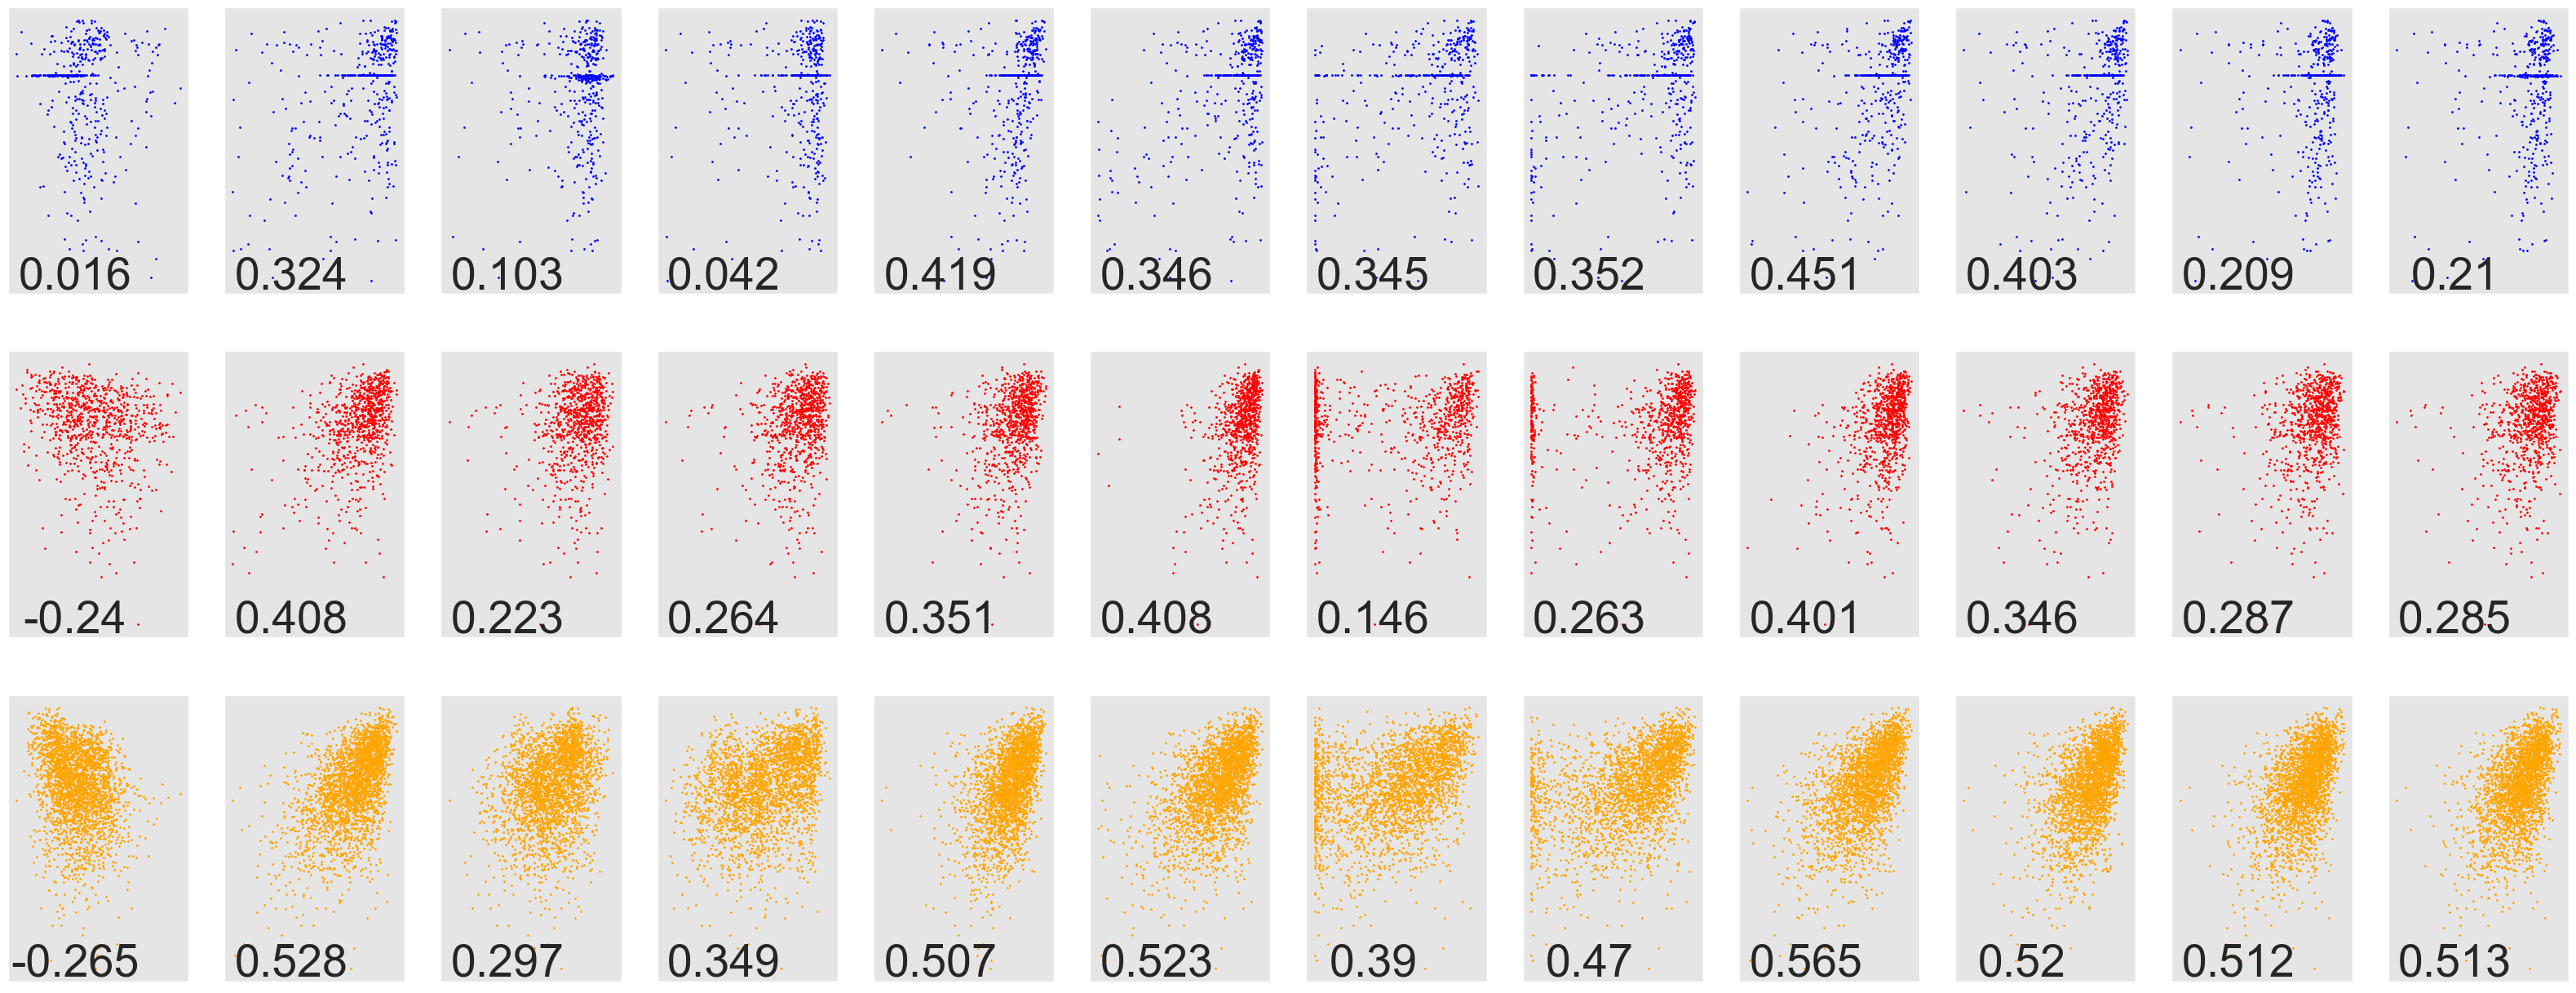

In [22]:
fig, axes = plt.subplots(nrows = 3, ncols = 12)
plt.style.use('ggplot')
cur_subplot = 0
# all_patients = list(bray_curtis_per_patient.keys())
all_methods = ["equal", "last time point", "average", "median", "KNN", "MLRR", "gLV MSE", "LIMITS", "spline",
              "weighted average", "sparse DBN", "dense DBN"]

# bc_cor_methods = ["Last and Next", "Same Sample", "Same Dataset", "Random"]
all_datasets = ['moving pictures', "donors", 'trosvic']
all_datasets_names = ['Caporaso', 'Poyet', 'Muinck & Trosvik']
colors_list = ["blue", "red", "orange"]
size_for_text = 50

pad = 5
# for ax, method in zip(axes[0], all_methods):
#     ax.annotate(method.replace(" ", "\n"), xy=(0.5, 1), xytext=(0, pad),
#                 xycoords='axes fraction', textcoords='offset points',
#                 ha='center', va='baseline', size = size_for_text)

# for ax, cor_dataset in zip(axes[:,0], all_datasets_names):
#     ax.annotate(cor_dataset.replace(" ", "\n"), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 ha='right', va='center', size = size_for_text)
tmp_tmp_tmp = []
for i in range(len(all_datasets)):
    cur_dataset = all_datasets[i]
    tmp_dataset_data = beta_div_cor_df[beta_div_cor_df["dataset"] == cur_dataset]
    for j in range(len(all_methods)):
        method = all_methods[j]
        ax = axes[i][j]
        tmp_data = tmp_dataset_data[tmp_dataset_data["method"] == method]
        tmp_data["distance"] = tmp_data["distance"].astype(float)
        tmp_data["Adjacent div."] = tmp_data["Adjacent div."].astype(float)
        ax.plot(tmp_data["distance"], tmp_data["Adjacent div."], ls = "",
                          marker=".",  markersize = 2, color = colors_list[i])
        tmp_data.corr(method='spearman').iloc[0,1]
        plt.text(0.37, 0.06, round(tmp_data.corr(method='spearman').iloc[0,1], 3),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax.transAxes,
        fontsize = "40")
        ax.set_xticks([])
        ax.set_yticks([])
#         if i != 2:
#             ax.set_xticks([])
#         elif j == 0 and i == 2:
#             ax.set_xticks([1])
#         else:
#             ax.set_xticks([0, 1])
#         if j != 0:
#             ax.set_yticks([])           
#         else:
#             ax.set_yticks([0, 1])
        

    
fig.set_size_inches(40.5, 15.5)


In [23]:
cur_dataset = all_datasets[0]
tmp_dataset_data = beta_div_cor_df[beta_div_cor_df["dataset"] == cur_dataset]
tmp_data = tmp_dataset_data[tmp_dataset_data["method"] == method]
tmp_data


dataset patient  Adjacent div.  distance     method
42004  moving pictures      M3       0.755617  0.811836  dense DBN
42005  moving pictures      M3       0.749210  0.767852  dense DBN
42006  moving pictures      M3       0.695218  0.696926  dense DBN
42007  moving pictures      M3       0.692147  0.630546  dense DBN
42008  moving pictures      M3       0.738224  0.879015  dense DBN
...                ...     ...            ...       ...        ...
45859  moving pictures      F4       0.821676  0.848572  dense DBN
45860  moving pictures      F4       0.821407  0.919231  dense DBN
45861  moving pictures      F4       0.821549  0.857292  dense DBN
45862  moving pictures      F4       0.821526  0.814096  dense DBN
45863  moving pictures      F4       0.821460  0.848343  dense DBN

[454 rows x 5 columns]

## bimodality

### calculation (takes some time)

In [24]:
bc_df_bimodal = pd.DataFrame(columns = ["dataset", "patient", "method" , "bimodal abundance", "distance (bc)"])
taxa_df_bimodal = pd.DataFrame(columns = ["dataset", "patient", "method","bimodal high\low" , "value", "taxa coef."])
bimodality_taxa_by_method = pd.DataFrame(columns = ["dataset", "patient" , "taxa", "bimodality"])


bi_coeff_min = 0.7
coef_threshold_for_taxa = 0.7


for patient in donors_data:
    print(datetime.now(), patient)
    numer = scipy.stats.skew(donors_data[patient], axis = 1) ** 2 + 1
    denom =  scipy.stats.kurtosis(donors_data[patient], axis = 1) 
    denom +=(((donors_data[patient].shape[1] - 1) ** 2) * 3) / (((donors_data[patient].shape[1] - 2) * (donors_data[patient].shape[1] - 3)))
    bi_coeff = numer /denom
    tmp_pat_bi_taxa = donors_data[patient][list(((bi_coeff) >bi_coeff_min))].iloc[:, 1:donors_data[patient].shape[1] - 1]
    tmp_pat_bi_taxa_sum = tmp_pat_bi_taxa.sum(axis=0)
    
    tmp_pat_bi_taxa = donors_data[patient][list(((bi_coeff) <=bi_coeff_min))].iloc[:, 1:donors_data[patient].shape[1] - 1]
    
    for i in range(len(bi_coeff)):
        bimodality_taxa_by_method = bimodality_taxa_by_method.append({"dataset": "donors", "patient": patient, 
                                  "taxa": list(donors_data[patient].index)[i], "bimodality": bi_coeff[i]}, ignore_index=True)
    
    for method in all_methods:
        
        cur_pat_bc = bray_curtis_per_patient["donors " + patient][method]
        for i in range(len(cur_pat_bc)):
            bc_df_bimodal = bc_df_bimodal.append({"dataset": "donors", "patient": patient, 
                                  "method" : method, "bimodal abundance": tmp_pat_bi_taxa_sum.iloc[i],
                                  "distance (bc)": cur_pat_bc[i]}, ignore_index=True)
            
        cur_pat_taxa = min_max_per_patient["donors " + patient][method]
        high_bi_taxa = cur_pat_taxa[bi_coeff > coef_threshold_for_taxa]
        low_bi_taxa = cur_pat_taxa[bi_coeff <= coef_threshold_for_taxa]
        for i in range(cur_pat_taxa.shape[0]):
            for j in range(cur_pat_taxa.shape[1]):
                taxa_df_bimodal = taxa_df_bimodal.append({"dataset": "donors", "patient": patient, 
                              "method" : method, "bimodal high\low":"high", 
                              "value": cur_pat_taxa[i,j], "taxa coef.": bi_coeff[i]}, ignore_index=True)
        
for patient in trosvic_data:
    print(datetime.now(), patient)
    numer = scipy.stats.skew(trosvic_data[patient], axis = 1) ** 2 + 1
    denom =  scipy.stats.kurtosis(trosvic_data[patient], axis = 1) 
    denom +=(((trosvic_data[patient].shape[1] - 1) ** 2) * 3) / (((trosvic_data[patient].shape[1] - 2) * (trosvic_data[patient].shape[1] - 3)))
    bi_coeff = numer /denom
    tmp_pat_bi_taxa = trosvic_data[patient][list(((bi_coeff) >bi_coeff_min))].iloc[:, 1:trosvic_data[patient].shape[1] - 1]
    tmp_pat_bi_taxa_sum = tmp_pat_bi_taxa.sum(axis=0)
    
    for i in range(len(bi_coeff)):
        bimodality_taxa_by_method = bimodality_taxa_by_method.append({"dataset": "trosvic", "patient": patient, 
                                  "taxa": list(trosvic_data[patient].index)[i], "bimodality": bi_coeff[i]}, ignore_index=True)
    
    for method in all_methods:
        
        cur_pat_bc = bray_curtis_per_patient["trosvic " + patient][method]
        for i in range(len(cur_pat_bc)):
            bc_df_bimodal = bc_df_bimodal.append({"dataset": "trosvic", "patient": patient, 
                                  "method" : method, "bimodal abundance": tmp_pat_bi_taxa_sum.iloc[i],
                                  "distance (bc)": cur_pat_bc[i]}, ignore_index=True)
            
        cur_pat_taxa = min_max_per_patient["trosvic " + patient][method]
        high_bi_taxa = cur_pat_taxa[bi_coeff > coef_threshold_for_taxa]
        low_bi_taxa = cur_pat_taxa[bi_coeff <= coef_threshold_for_taxa]
        for i in range(cur_pat_taxa.shape[0]):
            for j in range(cur_pat_taxa.shape[1]):
                taxa_df_bimodal = taxa_df_bimodal.append({"dataset": "trosvic", "patient": patient, 
                              "method" : method, "bimodal high\low":"high", 
                              "value": cur_pat_taxa[i,j], "taxa coef.": bi_coeff[i]}, ignore_index=True)
            
#Moving pictures

numer = scipy.stats.skew(moving_pictures_data, axis = 1) ** 2 + 1
denom =  scipy.stats.kurtosis(moving_pictures_data, axis = 1) 
denom +=(((moving_pictures_data.shape[1] - 1) ** 2) * 3) / (((moving_pictures_data.shape[1] - 2) * (moving_pictures_data.shape[1] - 3)))
bi_coeff = numer /denom
tmp_pat_bi_taxa = moving_pictures_data[list(((bi_coeff) >bi_coeff_min))].iloc[:, 1:moving_pictures_data.shape[1] - 1]
tmp_pat_bi_taxa_sum = tmp_pat_bi_taxa.sum(axis=0)



patient = "M3"
for i in range(len(bi_coeff)):
    bimodality_taxa_by_method = bimodality_taxa_by_method.append({"dataset": "moving pictures", "patient": patient, 
          "taxa": list(moving_pictures_data.index)[i], "bimodality": bi_coeff[i]}, ignore_index=True)
print(datetime.now(), patient)
for method in all_methods:
    cur_pat_bc = bray_curtis_per_patient["moving pictures " + patient][method]
    for i in range(len(cur_pat_bc)):
            bc_df_bimodal = bc_df_bimodal.append({"dataset": "Moving Pictures", "patient": patient, 
                                  "method" : method, "bimodal abundance": tmp_pat_bi_taxa_sum.iloc[i],
                                  "distance (bc)": cur_pat_bc[i]}, ignore_index=True)
    
        
    
    cur_pat_taxa = min_max_per_patient["moving pictures " + patient][method]
    high_bi_taxa = cur_pat_taxa[bi_coeff > coef_threshold_for_taxa]
    low_bi_taxa = cur_pat_taxa[bi_coeff <= coef_threshold_for_taxa]
    for i in range(cur_pat_taxa.shape[0]):
        for j in range(cur_pat_taxa.shape[1]):
            taxa_df_bimodal = taxa_df_bimodal.append({"dataset": "Moving Pictures", "patient": patient, 
                          "method" : method, "bimodal high\low":"high", 
                          "value": cur_pat_taxa[i,j], "taxa coef.": bi_coeff[i]}, ignore_index=True)


numer = scipy.stats.skew(moving_pictures_data_F4, axis = 1) ** 2 + 1
denom =  scipy.stats.kurtosis(moving_pictures_data_F4, axis = 1) 
denom +=(((moving_pictures_data_F4.shape[1] - 1) ** 2) * 3) / (((moving_pictures_data_F4.shape[1] - 2) * (moving_pictures_data_F4.shape[1] - 3)))
bi_coeff = numer /denom
tmp_pat_bi_taxa = moving_pictures_data_F4[list(((bi_coeff) >bi_coeff_min))].iloc[:, 1:moving_pictures_data_F4.shape[1] - 1]
tmp_pat_bi_taxa_sum = tmp_pat_bi_taxa.sum(axis=0)

patient = "F4"
print(datetime.now(), patient)
for i in range(len(bi_coeff)):
    bimodality_taxa_by_method = bimodality_taxa_by_method.append({"dataset": "moving pictures", "patient": patient, 
          "taxa": list(moving_pictures_data_F4.index)[i], "bimodality": bi_coeff[i]}, ignore_index=True)


for method in all_methods:
    
    cur_pat_bc = bray_curtis_per_patient["moving pictures " + patient][method]
    for i in range(len(cur_pat_bc)):
            bc_df_bimodal = bc_df_bimodal.append({"dataset": "Moving Pictures", "patient": patient, 
                                  "method" : method, "bimodal abundance": tmp_pat_bi_taxa_sum.iloc[i],
                                  "distance (bc)": cur_pat_bc[i]}, ignore_index=True)
    
    
    
    cur_pat_taxa = min_max_per_patient["moving pictures " + patient][method]
    high_bi_taxa = cur_pat_taxa[bi_coeff > coef_threshold_for_taxa]
    low_bi_taxa = cur_pat_taxa[bi_coeff <= coef_threshold_for_taxa]
    for i in range(cur_pat_taxa.shape[0]):
        for j in range(cur_pat_taxa.shape[1]):
            taxa_df_bimodal = taxa_df_bimodal.append({"dataset": "Moving Pictures", "patient": patient, 
                          "method" : method, "bimodal high\low":"high", 
                          "value": cur_pat_taxa[i,j], "taxa coef.": bi_coeff[i]}, ignore_index=True)

# moving_pictures_data, moving_pictures_data_F4

2024-04-15 17:02:27.453464 am
2024-04-15 17:05:08.766491 ao
2024-04-15 17:06:46.560368 ba
2024-04-15 17:09:26.628262 cl
2024-04-15 17:14:08.728983 ae
2024-04-15 17:16:33.395897 bh
2024-04-15 17:22:04.313077 co
2024-04-15 17:25:39.679920 bj
2024-04-15 17:30:05.149411 bc
2024-04-16 08:35:47.550780 ID1
2024-04-16 08:54:45.737675 ID2
2024-04-16 09:13:19.769990 ID3
2024-04-16 09:40:31.557931 ID4
2024-04-16 10:08:05.637463 ID5
2024-04-16 10:37:52.173611 ID6
2024-04-16 11:03:24.887867 ID7
2024-04-16 11:19:31.251839 ID8
2024-04-16 11:51:29.920239 ID9
2024-04-16 12:31:33.895018 ID10
2024-04-16 13:13:09.326504 ID11
2024-04-16 14:01:08.567146 ID12
2024-04-16 15:05:43.221386 M3
2024-04-17 10:14:03.340769 F4


## Relative error per method

Text(0.5, 0, 'Method')

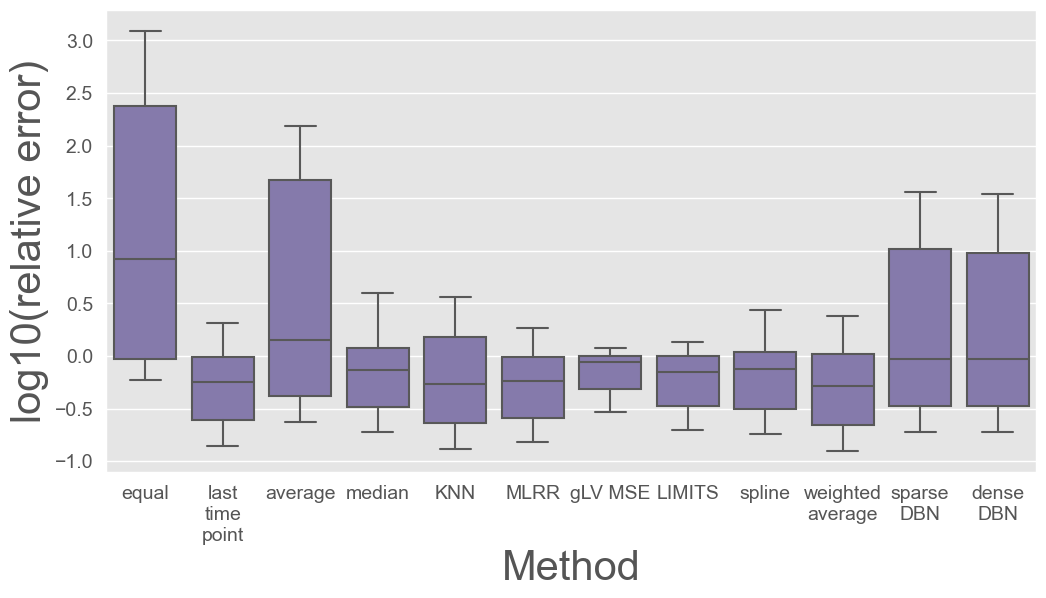

In [25]:
plt.figure(figsize=(12, 6))
copy_taxa_bi = copy.deepcopy(taxa_df_bimodal)
copy_taxa_bi["log10(relative error)"] = np.log10(copy_taxa_bi["value"])
copy_taxa_bi = copy_taxa_bi.replace("weighted average", "weighted\naverage").replace("sparse DBN", "sparse\nDBN").replace("dense DBN", "dense\nDBN").replace("last time point", "last\ntime\npoint")
copy_taxa_bi = copy_taxa_bi.dropna()
sns.boxplot(data = copy_taxa_bi, x = "method", y = "log10(relative error)",
           palette=["m"],  showfliers = False,whis=[15, 85])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel("log10(relative error)",  fontsize=30)
plt.xlabel("Method",  fontsize=30)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

(23, 1)
(23, 1)
(23, 1)
(23, 1)
(23, 1)
(23, 1)
(23, 1)
(23, 1)
(23, 1)
(23, 1)
(23, 1)


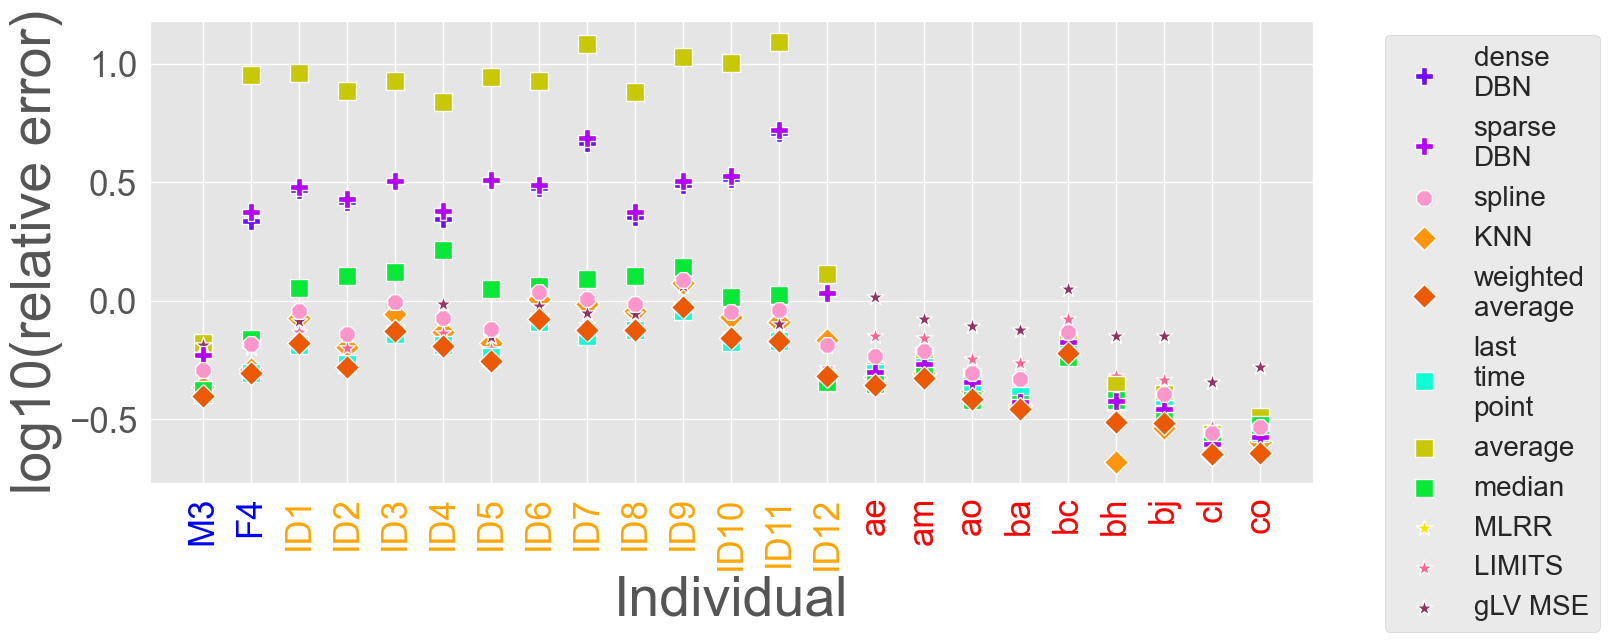

In [26]:
tmp_all_pat = [pat[::] for pat in list(copy_taxa_bi["patient"])]
# tmp_all_pat = [pat[:pat.find(" ")][::-1] for pat in tmp_all_pat]
tmp_bc_df = copy.deepcopy(copy_taxa_bi)
tmp_bc_df["patient"] = tmp_all_pat
drawing_ord = ["M3", "F4"]
for i in range(1,13):
    drawing_ord.append("ID" + str(i))
tmp_ord_donors = [pat[::-1] for pat in list(bc_df_donors["patient"])]
tmp_ord_donors = list(set([pat[:pat.find(" ")][::-1] for pat in tmp_ord_donors]))
tmp_ord_donors.sort()
[drawing_ord.append(tmp_pat) for tmp_pat in tmp_ord_donors]



plt.figure(figsize=(15,6))
tmp_to_draw = copy.deepcopy(tmp_bc_df)
# tmp_to_draw = tmp_bc_df[~((tmp_bc_df["method"] == "equal") | (tmp_bc_df["method"] == "gLV MSE") | (tmp_bc_df["method"] == "LIMITS"))]
tmp_to_draw = copy_taxa_bi[~((tmp_bc_df["method"] == "equal"))]
tmp_to_draw = tmp_to_draw[["method", "patient", "log10(relative error)"]]
tmp_to_draw.replace([np.inf, -np.inf], np.nan, inplace=True)
# tmp_to_draw = tmp_to_draw.dropna()
tmp = tmp_to_draw.groupby(by = ["method", "patient"]).mean().reset_index()
for method in tmp["method"].unique():
    sns.scatterplot(data = tmp[tmp["method"] == method], x="patient", y="log10(relative error)", label = method, s = 150,
                    c = color_per_method[method.replace("\n", " ")], 
                    marker=marker_per_method[method.replace("\n", " ")])
    print((tmp[tmp["method"] == method]).groupby(by = "patient").mean().shape)

plt.xticks(ticks=range(len(drawing_ord)), labels=drawing_ord, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=25)

# Set axis labels
plt.xlabel('Individual', fontsize=40)
plt.ylabel('log10(relative error)', fontsize=40)

# Color tick labels based on their group
for i, t in enumerate(plt.gca().get_xticklabels()):
    if i <= 1:
        t.set_color('blue')
    elif i <= 13:
        t.set_color('orange')
    else:
        t.set_color('red')


# Handling the legend
handles, labels = plt.gca().get_legend_handles_labels()

handles_labels_sorted = sorted(zip(handles, labels), key=lambda t: methods_to_draw_order.index(t[1].replace("\n", " ")))
handles_sorted, labels_sorted = zip(*handles_labels_sorted)

# Create a new legend with the sorted handles and labels
plt.legend(handles_sorted, labels_sorted, fontsize=20, ncol=1, loc='upper left', bbox_to_anchor=(1.05, 1))


# Adjusting legend marker size (if needed)
# for line in legend.get_lines():
#     line.set_markersize(16)  # Example size
plt.show()

# Monte Carlo

In [27]:
all_monte_carlo_data = {}
num_of_samples = [15]
importlib.reload(ToolsForTemporalAnalysis)
import datetime
repeats = 1000

for sample_size in num_of_samples:
    for patient in donors_data:
        print(patient, sample_size, datetime.datetime.now())
        if donors_data[patient].shape[1] > sample_size:
            all_monte_carlo_data["donors " + patient +";"+ str(sample_size)] = ToolsForTemporalAnalysis.monte_carlo(donors_data[patient], repeats, sample_size,
                7, 9.75, 9.75,
                0.065, 10,
                "D:\\", 2, donors_data[patient].shape[0] + 2)
    
    
    print("M3", sample_size, datetime.datetime.now())
    all_monte_carlo_data["moving pictures M3" +";"+ str(sample_size)] = ToolsForTemporalAnalysis.monte_carlo(moving_pictures_data, repeats, sample_size,
                7, 9.75, 9.75,
                0.065, 10,
                "D:\\", 2, moving_pictures_data.shape[0] + 2)
    
    print("F4", sample_size, datetime.datetime.now())
    all_monte_carlo_data["moving pictures F4" +";"+ str(sample_size)] = ToolsForTemporalAnalysis.monte_carlo(moving_pictures_data_F4, repeats, sample_size,
                7, 9.75, 9.75,
                0.065, 10,
                "D:\\", 2, moving_pictures_data_F4.shape[0] + 2)
        
    for patient in trosvic_data:
        print(patient, sample_size, datetime.datetime.now())
        all_monte_carlo_data["trosvic " + patient +";"+ str(sample_size)] = ToolsForTemporalAnalysis.monte_carlo(trosvic_data[patient], repeats, sample_size,
                7, 9.75, 9.75,
                0.065, 10,
                "D:\\", 2, trosvic_data[patient].shape[0] + 2)
        
monte_carlo_bc = {}
for key in all_monte_carlo_data.keys():
    patient, sample_size = key.split(";")
    if patient not in monte_carlo_bc.keys():
        monte_carlo_bc[patient] = {}
    if sample_size not in monte_carlo_bc[patient].keys():
        monte_carlo_bc[patient][sample_size] = {}
    for time_point_dif in all_monte_carlo_data[key].keys():
        tmp_real_data = np.array(all_monte_carlo_data[key][time_point_dif]["real_data"])
        tmp_patient = {}
        tmp_all_methods = list(all_monte_carlo_data[key][time_point_dif].keys())
        tmp_all_methods.remove("real_data")
        tmp_all_methods.remove("glv_MSE")
        tmp_all_methods.remove("glv_LIMITS")
        for method in tmp_all_methods:
            tmp_patient[method] = np.array(all_monte_carlo_data[key][time_point_dif][method])
        monte_carlo_bc[patient][sample_size][time_point_dif] = ToolsForTemporalAnalysis.bray_curtis_for_all_methods(tmp_real_data, tmp_patient)

all_data_per_sample = pd.DataFrame(columns = ["dataset", "patient", "time dif", "sample size", "method", "BC"])
patient = "moving pictures M3"
for patient in monte_carlo_bc.keys():
    print(patient)
    for sample_size in monte_carlo_bc[patient]:
        for time_dif in monte_carlo_bc[patient][sample_size]:
            for method in monte_carlo_bc[patient][sample_size][time_dif]:
                for val in monte_carlo_bc[patient][sample_size][time_dif][method]:
                    tmp_dict = {"dataset": patient[:-patient[::-1].find(" ") - 1],
                               "patient": patient[-patient[::-1].find(" ") :], "time dif": time_dif,
                               "sample size": int(sample_size), "method": method, "BC": val}
                    all_data_per_sample = all_data_per_sample.append(tmp_dict, ignore_index= True)
                

    
    
     
all_data_per_sample.to_csv("D:\\אוניברסיטה\\מעבדה\\all interpolation results\\monte carlo results\\monte_carlo_res.csv")   

am 15 2024-04-17 10:47:59.645805


MatlabExecutionError: Execution of script learnDynamicBayesNetwork as a function is not supported:
C:\Users\Omri\OneDrive - mail.tau.ac.il\מסמכים\MATLAB\learnDynamicBayesNetwork.m


In [29]:
all_monte_carlo_data = None
# all_data_per_sample = pd.read_csv("D:\\אוניברסיטה\\מעבדה\\all interpolation results\\monte carlo results\\monte_carlo_unified_results.csv")
all_data_per_sample = pd.read_csv("monte_carlo_unified_results.csv")

In [30]:
methods_to_replace = {"average_data": "average", "dbn_dense_normal": "dense DBN", "dbn_sparse_normal": "sparse DBN", 
                      "equal": "equal", "glv_data": "MLRR", "knn_kernel_data": "KNN", 
                      "last_time_point_vals": "last time point", "median_data": "median",
                      "spline_vals": "spline", "weighted_avg_vals": "weighted average",}
all_data_per_sample = all_data_per_sample.replace(to_replace=methods_to_replace)
all_data_per_sample = all_data_per_sample.replace(to_replace={"moving pictures": "dataset 1",
                                                             "donors": "dataset 2", "trosvic": "dataset 3"})
colors_for_pat = {'F4': "blue", 'ID1': "orange", 'ID10': "orange", 'ID11': "orange", 'ID12': "orange",
 'ID2': "orange", 'ID3': "orange", 'ID4': "orange", 'ID5': "orange", 'ID6': "orange",
 'ID7': "orange", 'ID8': "orange", 'ID9': "orange", 'M3' : "blue", 'ae': "red",
 'am': "red", 'ao': "red", 'ba': "red", 'bc': "red", 'bh': "red", 'bj': "red",'cl': "red",'co': "red"}
methods_to_draw_order = ['MLRR', 'dense DBN', 'sparse DBN', 'spline', 'KNN', 'weighted average', 
                         'last time point', 'average', 'median']

In [31]:
cor_results = pd.DataFrame(columns=["method", "dataset", "Individual", "correlation"])

for method in methods_to_draw_order:
    for patient in set(all_data_per_sample["patient"]):
        tmp_data = all_data_per_sample[(all_data_per_sample["method"] == method) & (all_data_per_sample["patient"] == patient)]

        cor_results = cor_results.append({"method": method, "dataset": tmp_data.iloc[0]["dataset"], 
                    "Individual":patient, 
                    "correlation": tmp_data.corr("spearman")["sample size"]["BC"]}, ignore_index = True)
cor_results = cor_results.groupby(by = ["method", "dataset"]).mean().reset_index()
cor_results = cor_results.pivot(index="dataset", columns="method", values="correlation")

### accuracy to sample size and time difference correlation

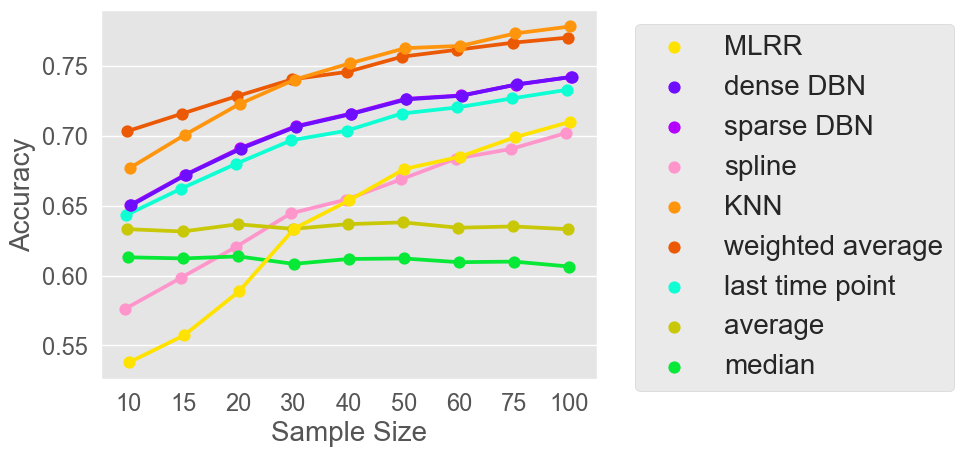

In [32]:
cur_selection = np.zeros(all_data_per_sample.shape[0])
for patient in set(all_data_per_sample[all_data_per_sample["sample size"] == 100]["patient"]):
    cur_selection = cur_selection | (all_data_per_sample["patient"] == patient)

tmp_data = all_data_per_sample[cur_selection]
tmp_data = tmp_data[tmp_data["method"] != "equal"]
tmp_data = tmp_data[tmp_data["sample size"] != 150]
tmp_data = tmp_data[tmp_data["sample size"] != 125]
sns.pointplot(x="sample size", y="BC", hue="method",  legend = False, dodge = 0.1, ci = False,
        data= tmp_data, palette=color_per_method)
plt.ylabel("Accuracy", fontsize=20)
plt.xlabel("Sample Size", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.style.use('ggplot')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 17})

# Handling the legend
handles, labels = plt.gca().get_legend_handles_labels()

handles_labels_sorted = sorted(zip(handles, labels), key=lambda t: methods_to_draw_order.index(t[1]))
handles_sorted, labels_sorted = zip(*handles_labels_sorted)

# Create a new legend with the sorted handles and labels
plt.legend(handles_sorted, labels_sorted, fontsize=20, ncol=1, loc='upper left', bbox_to_anchor=(1.05, 1))


plt.show()

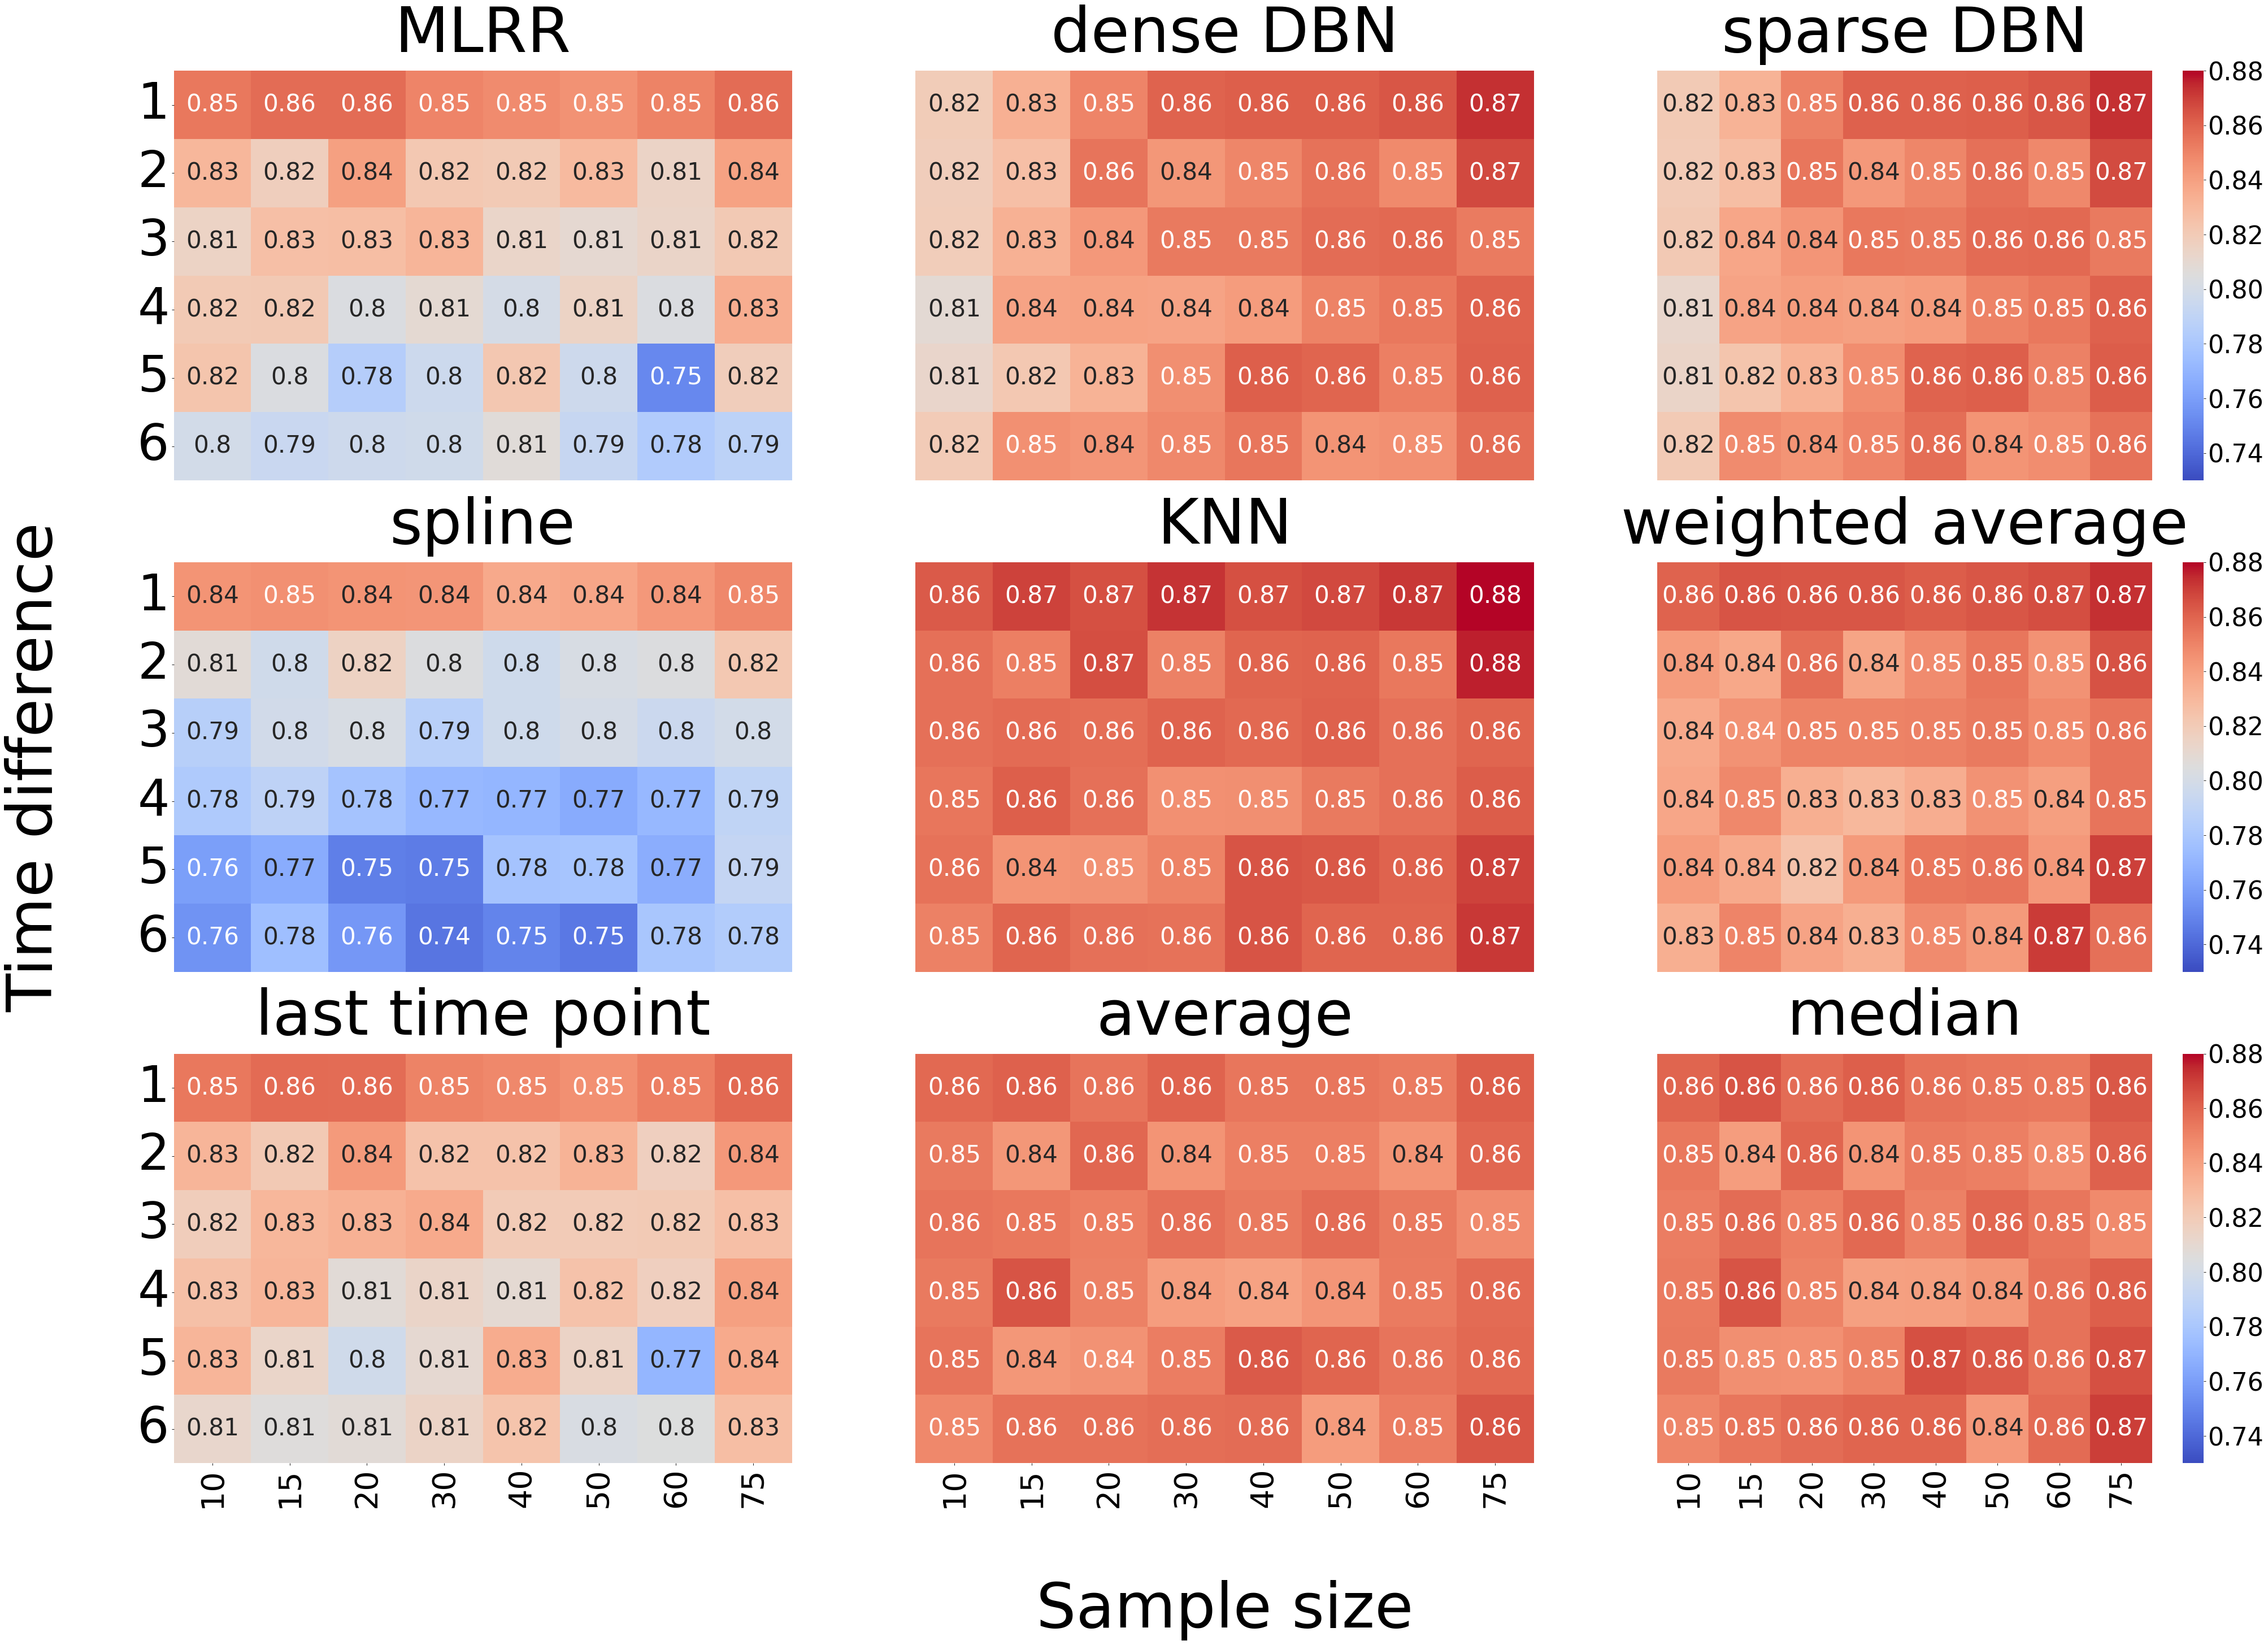

In [33]:
fig = plt.figure(figsize=(60, 40), dpi=80, frameon=False)

plt.style.use('default')
i = 0
cur_plt = fig.add_subplot(1, len(list(set(all_data_per_sample["method"]))), 1)

plt.axis('off')



for method in methods_to_draw_order:
    if method in ["LIMITS", "gLV MSE"]:
        continue
    i += 1
    cur_plt = fig.add_subplot(3, 3, i)


    tmp_data = all_data_per_sample[(all_data_per_sample["method"] == method) & (all_data_per_sample["dataset"] != "dataset 3")].groupby(by = ["patient", "sample size", "time dif"]).mean().groupby(by = ["sample size", "time dif"]).mean()
    tmp_data = tmp_data[tmp_data.index.get_level_values(0) < 100]
    tmp_data = tmp_data[tmp_data.index.get_level_values(1) <= 6]
    td_ss_df = pd.DataFrame()
    for j in range(tmp_data.shape[0]):
        sample_size = tmp_data.index[j][0]
        time_dif = tmp_data.index[j][1]
        tmp_bc_data = float(tmp_data.iloc[j])
        td_ss_df.loc[time_dif, sample_size] = tmp_bc_data
#     print(method, np.min(np.min(td_ss_df)), np.max(np.max(td_ss_df)))
    if i in [3,6,9]:
        ax = sns.heatmap(td_ss_df.astype(float), vmin = 0.73, vmax = 0.88, cmap = "coolwarm", mask=td_ss_df.isnull(),
                         annot=True, annot_kws={"fontsize":38})
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=40)

    else:
        sns.heatmap(td_ss_df.astype(float), vmin = 0.73, vmax = 0.88,cmap = "coolwarm", cbar=False, mask=td_ss_df.isnull(),
                    annot=True, annot_kws={"fontsize":38})
    
    if i not in [1, 4, 7]:
        cur_plt.set_yticks([])
    else:
        plt.yticks(rotation=0, size = 80)
        if i == 4:
            plt.ylabel('Time difference\n', size = 100)
    if i < 7:
        cur_plt.set_xticks([])
    else:
#         cur_plt.set_xticks(sorted(list(set(tmp_data.index.get_level_values(0)))))
        plt.xticks(rotation=90, size = 50)
    if i == 8:
        plt.xlabel('\nSample size', size = 100)
    
    plt.title(method , size = 100, pad = 30)


plt.show()

    

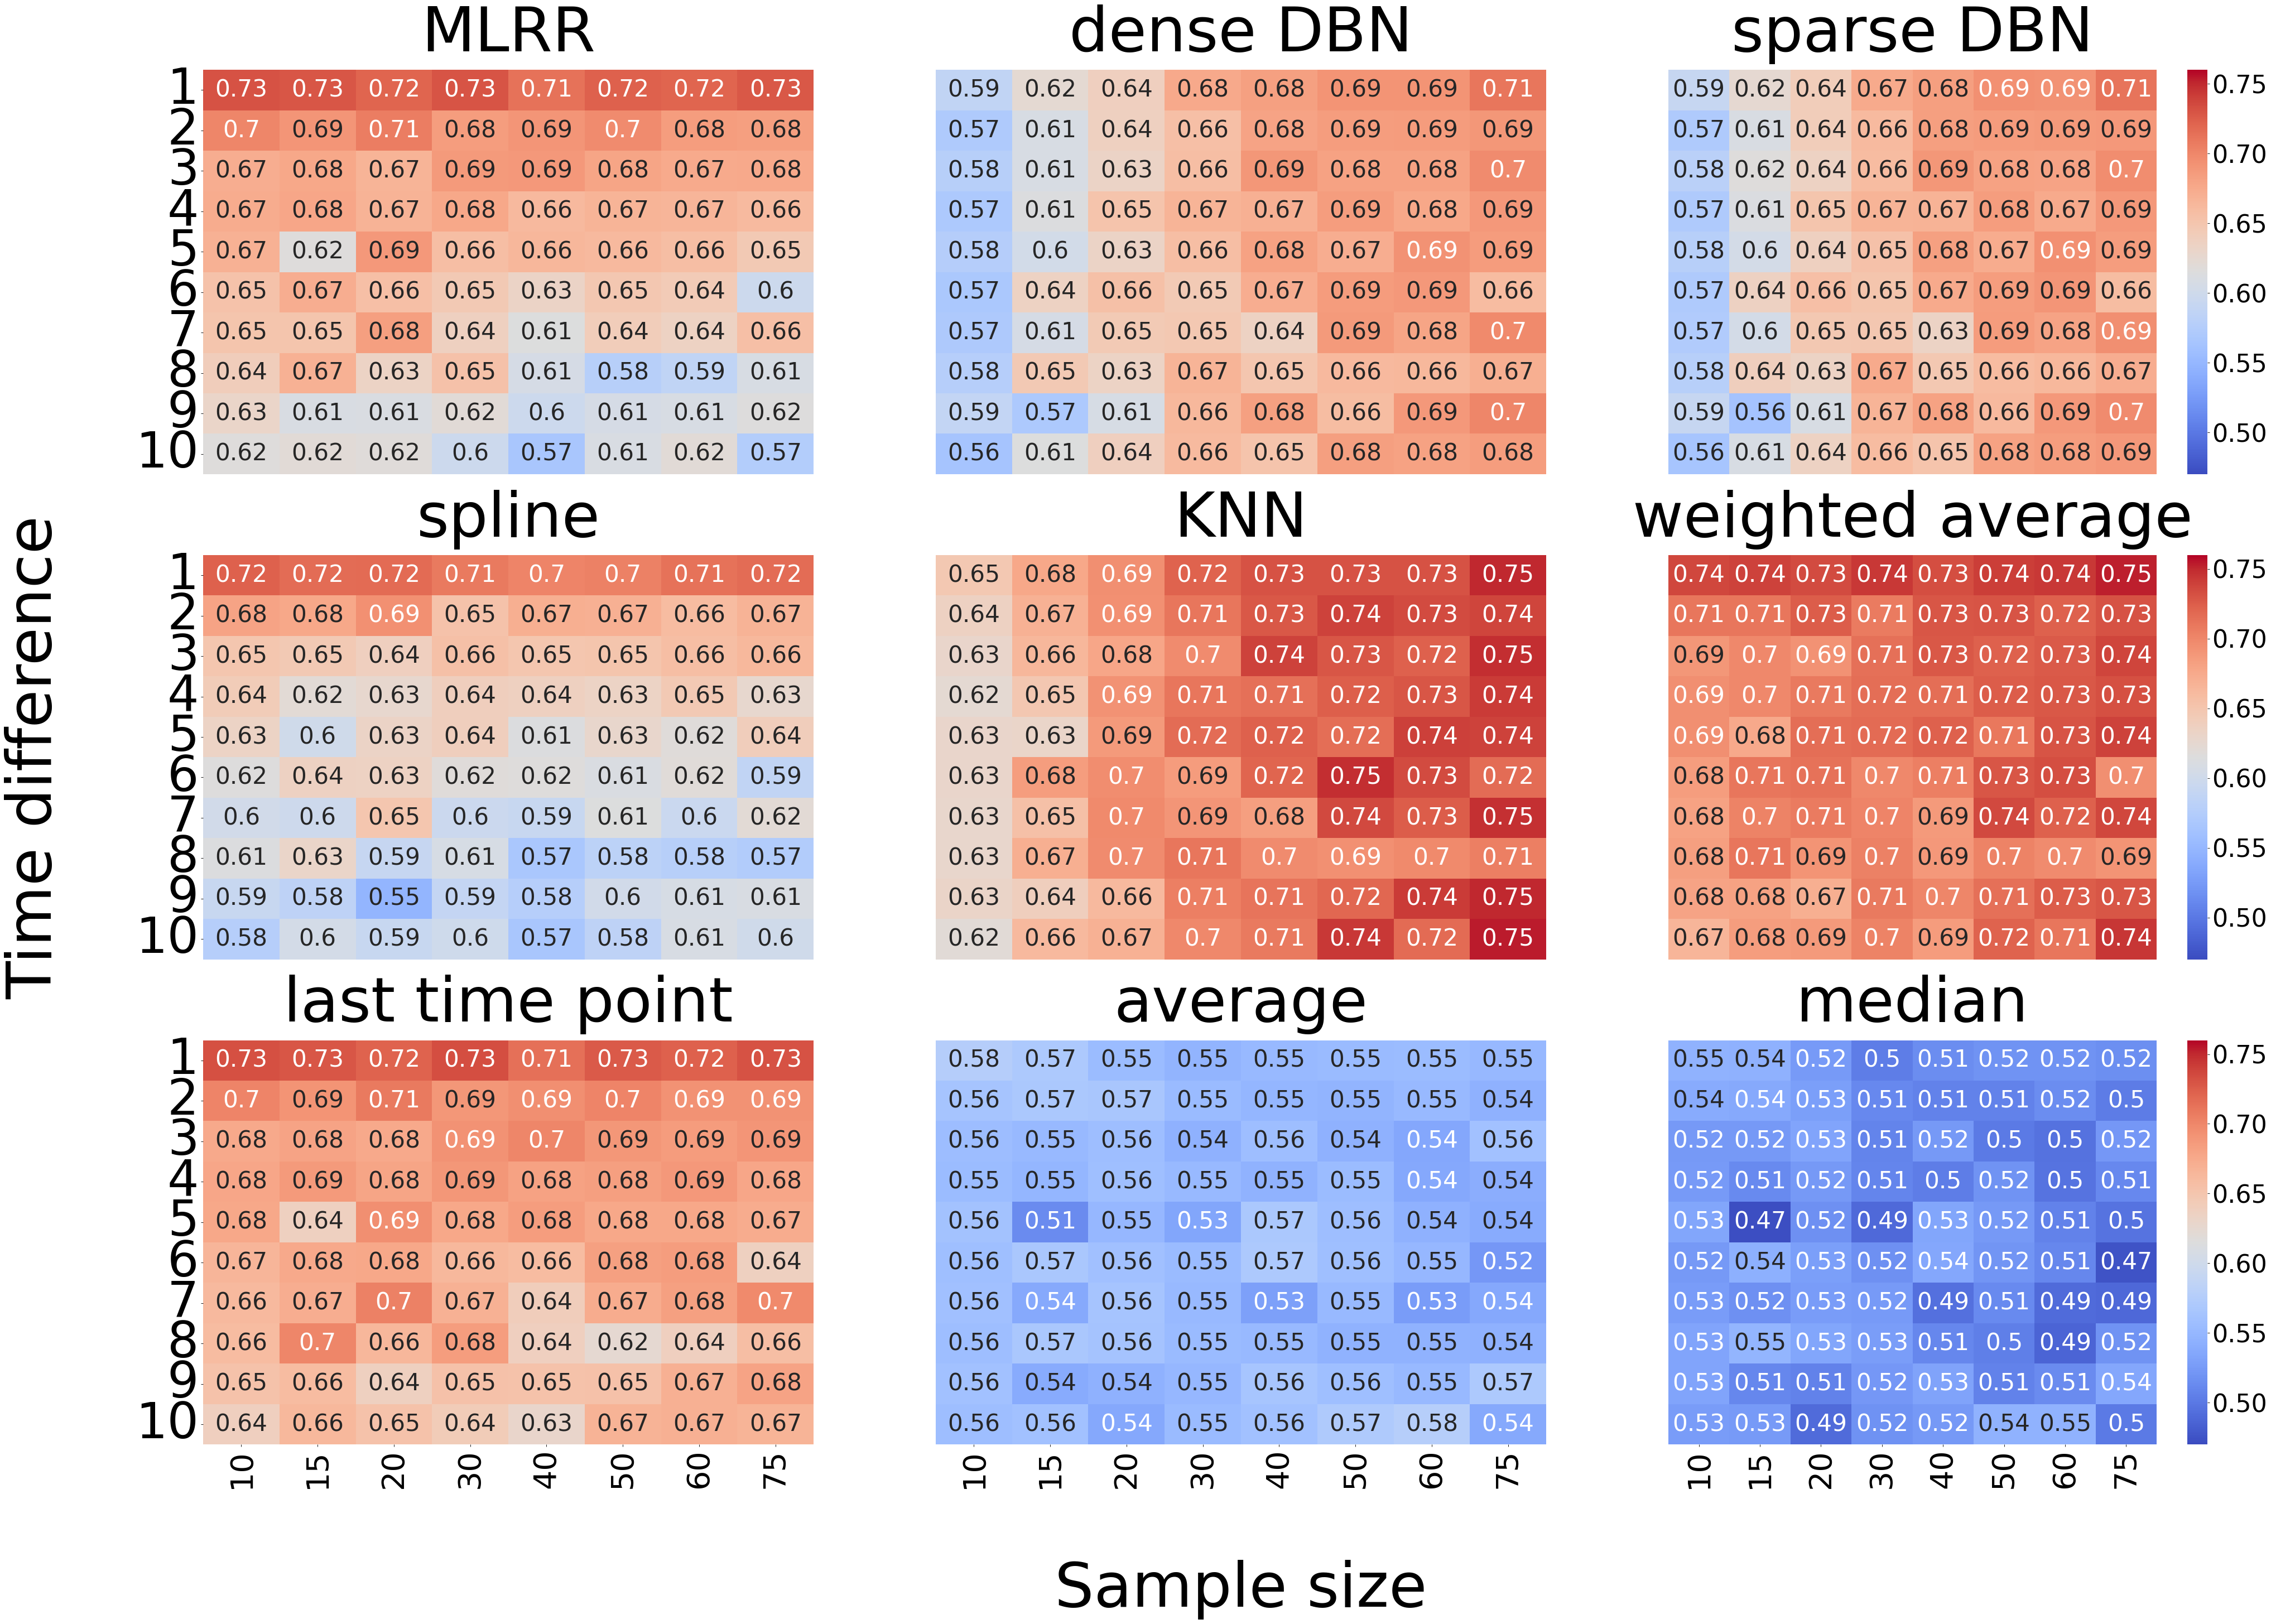

In [34]:
fig = plt.figure(figsize=(60, 40), dpi=80, frameon=False)

plt.style.use('default')
i = 0
cur_plt = fig.add_subplot(1, len(list(set(all_data_per_sample["method"]))), 1)

plt.axis('off')



for method in methods_to_draw_order:
    if method in ["LIMITS", "gLV MSE"]:
        continue
    i += 1
    cur_plt = fig.add_subplot(3, 3, i)


    tmp_data = all_data_per_sample[(all_data_per_sample["method"] == method) & (all_data_per_sample["dataset"] == "dataset 3")].groupby(by = ["patient", "sample size", "time dif"]).mean().groupby(by = ["sample size", "time dif"]).mean()
    tmp_data = tmp_data[tmp_data.index.get_level_values(0) < 100]
    tmp_data = tmp_data[tmp_data.index.get_level_values(1) <= 10]
    td_ss_df = pd.DataFrame()
    for j in range(tmp_data.shape[0]):
        sample_size = tmp_data.index[j][0]
        time_dif = tmp_data.index[j][1]
        tmp_bc_data = float(tmp_data.iloc[j])
        td_ss_df.loc[time_dif, sample_size] = tmp_bc_data
#     print(method, np.min(np.min(td_ss_df)), np.max(np.max(td_ss_df)))
    if i in [3,6,9]:
        ax = sns.heatmap(td_ss_df.astype(float), vmin = 0.47, vmax = 0.76, cmap = "coolwarm", mask=td_ss_df.isnull(),
                        annot=True, annot_kws={"fontsize":38})
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=40)

    else:
        sns.heatmap(td_ss_df.astype(float), vmin = 0.47, vmax = 0.76,cmap = "coolwarm", cbar=False, mask=td_ss_df.isnull(),
                   annot=True, annot_kws={"fontsize":38})
    
    if i not in [1, 4, 7]:
        cur_plt.set_yticks([])
    else:
        plt.yticks(rotation=0, size = 80)
        if i == 4:
            plt.ylabel('Time difference\n', size = 100)
    if i < 7:
        cur_plt.set_xticks([])
    else:
#         cur_plt.set_xticks(sorted(list(set(tmp_data.index.get_level_values(0)))))
        plt.xticks(rotation=90, size = 50)
    if i == 8:
        plt.xlabel('\nSample size', size = 100)
    
    plt.title(method , size = 100, pad = 30)


plt.show()

    